# Corporación Favorita Grocery Sales Forecasting
### _Can you accurately predict sales for a large grocery chain?_
#### https://www.kaggle.com/c/favorita-grocery-sales-forecasting/overview
---

# 目次

1. **[プロジェクト概要](#1)**
2. **[データクリーニング](#2)**
3. **[探索的データ解析](#3)**
4. **[特徴量エンジニアリング](#4)**
5. **[機械学習](#5)**
6. **[結果、まとめ](#6)**

# 1, プロジェクト概要 <a id="1"></a>

### 1.1 プロジェクトの説明
- "*Corporación Favorita Grocery Sales Forecasting*"はCorporación Favoritaと言うエクアドルのスーパーマーケット業界の企業が提供するコンペティションで、与えられたデータを元に指定された日付、店舗での各商品の売上を予測するプロジェクトです。<br>

### 1.2 評価指標の説明
評価指標はNormalized Weighted Root Mean Squared Logarithmic Error(NWRMSLE)を使う。<br>
$$ NWRMSLE = \sqrt{ \frac{\sum_{i=1}^{n} wi \left( \log(\hat{y}_{i} + 1) - \log(y_{i} +1)  \right)^2  }{\sum_{i=1}^{n} w_{i}}} $$
- w(サンプルの重さ)にはitems.csvの'perishable'(その商品が腐りやすいかどうか)を使う。腐りやすい商品は1.25、腐りにくい商品は1で計算される。
- Corporación Favoritaは廃棄を少なくしたいため、なるべく腐りやすい商品の売上を正確に予測して欲しい。

### 1.3 与えられた各csvファイルの説明

train.csv
- id: id 
- data: その商品の売上の日付
- store_nbr: 店舗番号
- item_nbr: 商品番号
- unit_sales(ターゲット): その商品の売上
- onpromotion: プロモーションがされていたかどうか

stores.csv
- store_nbr: 店舗番号
- city: 町,市の名前
- state: 州の名前
- type: 店舗の種類
- cluster: 似たような店舗を番号でグループ分けされていて、その番号

items.csv
- item_nbr: 商品番号
- family: 商品の種類(FROZEN FOODS,HOME CARE,BEVERAGES, など)
- class: クラス
- perishable: 腐りやすいかどうか(0,又は1)

transactions.csv(指定された店舗、日付での販売取引の数を知るためのファイル)
- date: 日付
- store_nbr: 店舗
- transactions: 指定された店舗、日付での販売取引の数

holidays_events.csv(指定された日付がどんな祝日であったか)
- date: 日付
- type: 祝日のタイプ(Holiday, Event など)
- locale: ナショナルホリデーか、ローカルの祝日か、一部の宗教だけの祝日か、
- locale_name: 祝日だった地域
- description: 祝日の説明(スペイン語)
- transferred: 本来その日付が祝日だが何らかの理由(日曜日だった)で違う日にずらされたかどうか

oil.csv(指定された日付での石油価格(エクアドルは石油産業が盛んで石油価格がエクアドル経済に大きく左右される))
- date: 日付
- dcoilwtico: 石油価格

# 2, データクリーニング <a id="2"></a>

### 2.1 データを読み込む

In [1]:
#1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
#2
train_df_original = pd.read_csv('train.csv')
test_df_original = pd.read_csv('test.csv')
sample_submission_df_original = pd.read_csv('sample_submission.csv')
stores_df_original = pd.read_csv('stores.csv')
items_df_original = pd.read_csv('items.csv')
transactions_df_original = pd.read_csv('transactions.csv')
oil_df_original = pd.read_csv('oil.csv')
holidays_events_df_original = pd.read_csv('holidays_events.csv')


In [3]:
#3
train_df = train_df_original.copy()
test_df = test_df_original.copy()
sample_submission_df = sample_submission_df_original.copy()
stores_df = stores_df_original.copy()
items_df = items_df_original.copy()
transactions_df = transactions_df_original.copy()
oil_df = oil_df_original.copy()
holidays_events_df = holidays_events_df_original.copy()


In [4]:
#4
#train_df, test_dfの'date'をdatetime64に変換する
train_df["date"] = pd.to_datetime(train_df["date"], format="%Y-%m-%d")
test_df["date"] = pd.to_datetime(test_df["date"], format="%Y-%m-%d")

### 2.2 データの概要を把握する

In [5]:
#5
#train.csvを確認
train_df

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN
...,...,...,...,...,...,...
125497035,125497035,2017-08-15,54,2089339,4.0,False
125497036,125497036,2017-08-15,54,2106464,1.0,True
125497037,125497037,2017-08-15,54,2110456,192.0,False
125497038,125497038,2017-08-15,54,2113914,198.0,True


In [6]:
#6
#test.csvを確認
test_df

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False
...,...,...,...,...,...
3370459,128867499,2017-08-31,54,2132163,False
3370460,128867500,2017-08-31,54,2132318,False
3370461,128867501,2017-08-31,54,2132945,False
3370462,128867502,2017-08-31,54,2132957,False


train.csv, test.csv
- id: id 
- data: その商品の売上の日付
- store_nbr: 店舗番号
- item_nbr: 商品番号
- unit_sales(ターゲット): その商品の売上
- onpromotion: プロモーションがされていたかどうか

train.csvを確認:
- データセットは1億2500万ある、かなり多い。
- 日付はトレインデータは 2013-01-01 ~ 2017-08-15、　テストデータは 2017-08-16 ~ 2017-08-31

In [7]:
#7
#stores.csvを確認
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


stores.csv
- store_nbr: 店舗番号
- city: 町,市の名前
- state: 州の名前
- type: 店舗の種類
- cluster: 似たような店と番号でグループ分けされている(cluster is a grouping of similar stores.)

In [8]:
#8
#items.csvを確認
items_df.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


items.csv
- item_nbr: 商品番号
- family: 商品の種類(FROZEN FOODS,HOME CARE,BEVERAGES, など)
- class: クラス
- perishable: 腐りやすいかどうか(0,又は1)

In [9]:
#9
#transactions.csvを確認
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


transactions.csv(指定された店舗、日付での販売取引の数を知るためのファイル)
- date: 日付
- store_nbr: 店舗
- transactions: 指定された店舗、日付での販売取引の数

In [10]:
#10
#oil.csvを確認
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


oil.csv(指定された日付での石油価格(エクアドルは石油産業が盛んで石油価格がエクアドル経済に大きく左右される))
- date: 日付
- dcoilwtico: 石油価格

In [11]:
#11
#holidays_events.csvを確認
holidays_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


holidays_events.csv(指定された日付がどんな祝日であったか)
- date: 日付
- type: 祝日のタイプ(Holiday, Event など)
- locale: ナショナルホリデーか、ローカルの祝日か、一部の宗教だけの祝日か、
- locale_name: 祝日だった地域
- description: 祝日の説明(スペイン語)
- transferred: 本来その日付が祝日だが何らかの理由(日曜日だった)で違う日にずらされたかどうか

### 2.3 データの欠損値を確認

In [12]:
#12
train_df.isnull().sum()

id                    0
date                  0
store_nbr             0
item_nbr              0
unit_sales            0
onpromotion    21657651
dtype: int64

In [13]:
#13
stores_df.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [14]:
#14
items_df.isnull().sum()

item_nbr      0
family        0
class         0
perishable    0
dtype: int64

In [15]:
#15
transactions_df.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [16]:
#16
oil_df.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [17]:
#17
holidays_events_df.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

### 2.4 データの分析で探索的データ解析で扱いやすいように手を加える

In [18]:
#18
#train_df, test_dfを連結
df_concat = pd.concat([train_df, test_df])

In [19]:
#19

#df_concatをのカラム'onpromotion'(プロモーションがされていたかどうか)の値を以下に変更する.
# NaN => unknown
# True => yes
# False => no

def bool_to_str(x):
    if pd.isnull(x) == True:
        return 'unknown'
    elif x == True:
        return 'yes'
    else:
        return 'no'
df_concat['onpromotion'] = df_concat['onpromotion'].apply(bool_to_str)


#df_concatをの'date'をdatetime64に変換する
df_concat["date"] = pd.to_datetime(df_concat["date"], format="%Y-%m-%d")


#df_concatの年、月、日、曜日のカラムを追加する。
df_concat['day_of_week'] = df_concat["date"].dt.day_name()
df_concat['year'] = df_concat["date"].dt.year
df_concat['month'] = df_concat["date"].dt.month
df_concat['day'] = df_concat["date"].dt.day

In [20]:
#20

#stores_dfのカラム名を'stores_~'に変更する
stores_df = stores_df.rename(columns={'city':'stores_city','state':'stores_state','type':'stores_type','cluster':'stores_cluster'})


In [21]:
#21

#items_dfのカラム名を'items_~'に変更する
items_df = items_df.rename(columns={'family':'items_family','class':'items_class','perishable':'items_perishable'})

In [22]:
#22

#transactions_dfのdate'をdatetime64に変換する
transactions_df["date"] = pd.to_datetime(transactions_df["date"], format="%Y-%m-%d")

#transactions_dfのカラム名を'trans_~'に変更する
transactions_df= transactions_df.rename(columns={'transactions':'trans_transactions'})

In [23]:
#23

#oil_df

#oil_dfの'date'をdatetime64に変換する
oil_df["date"] = pd.to_datetime(oil_df["date"], format="%Y-%m-%d")

#oil_dfの'dcoilwtico'(石油価格)の欠損値を次の日の値で埋める
#例 2013-1-1: NaN,  2013-1-2: 93  => 2013-1-1: 93,  2013-1-2: 93
dcoilwtico_sort = oil_df.sort_values('date')['dcoilwtico']
if pd.isnull(dcoilwtico_sort.iloc[0]) == True and pd.isnull(dcoilwtico_sort.iloc[-1]) == False:
    oil_df['dcoilwtico'] = dcoilwtico_sort.fillna(method = 'bfill').sort_index()
elif pd.isnull(dcoilwtico_sort.iloc[0]) == False and pd.isnull(dcoilwtico_sort.iloc[-1]) == True:
    oil_df['dcoilwtico'] = dcoilwtico_sort.fillna(method = 'ffill').sort_index()
else:
    oil_df['dcoilwtico'] = dcoilwtico_sort.fillna(method = 'bfill').sort_index()
    oil_df["dcoilwtico"] = oil_df["dcoilwtico"].fillna(oil_df["dcoilwtico"].mean())

#oil_dfのカラム名を'oil_~'に変更する
oil_df = oil_df.rename(columns={'dcoilwtico':'oil_dcoilwtico'})

#年、月、日、曜日のカラムを追加する。
oil_df['day_of_week'] = oil_df["date"].dt.day_name()
oil_df['year'] = oil_df["date"].dt.year
oil_df['month'] = oil_df["date"].dt.month
oil_df['day'] = oil_df["date"].dt.day

In [24]:
#24

#holidays_events_df

#holidays_events_dfの'date'をdatetime64に変換する
holidays_events_df["date"] = pd.to_datetime(holidays_events_df["date"], format="%Y-%m-%d")

#holidays_events_dfの'description'を削除(祝日の説明は必要ない)
holidays_events_df = holidays_events_df.drop('description', axis=1)

#holidays_events_dfの'transferred'の値がTrueの行を削除(祝日の日にちが変更されて結局のそ日は祝日ではないのでその情報は必要ない)
#holidays_events_dfのカラム'transferred'の値はFalseのみになり必要なくなるので削除する。
holidays_events_df = holidays_events_df[holidays_events_df['transferred']==False]
holidays_events_df = holidays_events_df.drop('transferred', axis=1)

#holidays_events_dfのカラム名を'holidays_~'に変更する
holidays_events_df = holidays_events_df.rename(columns={'type':'holidays_type','locale':'holidays_locale','locale_name':'holidays_locale_name'})

### 2.5 データフレームを結合する

In [25]:
#25

#df_concatとstores_dfを結合する
concat_merge_df = df_concat.merge(stores_df, on='store_nbr', how='left')

In [26]:
#26

#train_merge_df、test_merge_dfとitems_dfを結合する
concat_merge_df = concat_merge_df.merge(items_df, on='item_nbr', how='left')

In [27]:
#27

#train_merge_dfとtransactions_dfを結合する
concat_merge_df = concat_merge_df.merge(transactions_df, on=['date','store_nbr'], how='left')

In [28]:
#28

#train_merge_df、test_merge_dfとoil_dfを結合する
concat_merge_df = concat_merge_df.merge(oil_df.drop(['day_of_week','year','month', 'day'], axis=1), on='date', how='left')

In [29]:
#29

#train_merge_df、test_merge_dfとholidays_events_dfを結合する
concat_merge_df = concat_merge_df.merge(holidays_events_df, on='date', how='left')

### 2.6 結合したデータフレームの欠損値を埋める、いらないカラムを削除する

In [30]:
#30

#結合したデータフレームの欠損値を確認
concat_merge_df.isnull().sum()

id                              0
date                            0
store_nbr                       0
item_nbr                        0
unit_sales                3370464
onpromotion                     0
day_of_week                     0
year                            0
month                           0
day                             0
stores_city                     0
stores_state                    0
stores_type                     0
stores_cluster                  0
items_family                    0
items_class                     0
items_perishable                0
trans_transactions        3585089
oil_dcoilwtico           39768779
holidays_type           109997032
holidays_locale         109997032
holidays_locale_name    109997032
dtype: int64

In [31]:
#31

#trans_transactions(指定された店舗、日付での販売取引の数)の欠損値は店舗の平均で埋める)
concat_merge_df['trans_transactions'] = concat_merge_df['trans_transactions'].fillna(concat_merge_df['trans_transactions'].mean())

In [32]:
#32

#'oil_dcoilwtico'(石油価格)の欠損値を次の日の値で埋める
#例 2013-1-1: NaN,  2013-1-2: 93  => 2013-1-1: 93,  2013-1-2: 93
oil_dcoilwtico_sort_date = concat_merge_df.sort_values('date')['oil_dcoilwtico']
if pd.isnull(oil_dcoilwtico_sort_date.iloc[0]) == True and pd.isnull(oil_dcoilwtico_sort_date.iloc[-1]) == False:
    concat_merge_df['oil_dcoilwtico'] = oil_dcoilwtico_sort_date.fillna(method = 'bfill').sort_index()
elif pd.isnull(oil_dcoilwtico_sort_date.iloc[0]) == False and pd.isnull(oil_dcoilwtico_sort_date.iloc[-1]) == True:
    concat_merge_df['oil_dcoilwtico'] = oil_dcoilwtico_sort_date.fillna(method = 'ffill').sort_index()
else:
    concat_merge_df['oil_dcoilwtico'] = oil_dcoilwtico_sort_date.fillna(method = 'bfill').sort_index()
    concat_merge_df['oil_dcoilwtico'] =  concat_merge_df['oil_dcoilwtico'].fillna(concat_merge_df['oil_dcoilwtico'].mean())

In [33]:
#33

#'holidays_typeの'欠損値をnot_holidayで埋める
concat_merge_df['holidays_type'] = concat_merge_df['holidays_type'].fillna('not_holiday')

In [34]:
#34

#'holidays_locale'の欠損値をnot_holidayで埋める
concat_merge_df['holidays_locale'] = concat_merge_df['holidays_locale'].fillna('not_holiday')


In [35]:
#35

#'holidays_locale_name'の欠損値をnot_holidayで埋める
concat_merge_df['holidays_locale_name'] = concat_merge_df['holidays_locale_name'].fillna('not_holiday')

In [36]:
#36

#'id'を削除
concat_merge_df = concat_merge_df.drop('id', axis=1)

In [37]:
#37

#結合したデータフレームを確認
concat_merge_df.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,day_of_week,year,month,day,stores_city,...,stores_type,stores_cluster,items_family,items_class,items_perishable,trans_transactions,oil_dcoilwtico,holidays_type,holidays_locale,holidays_locale_name
0,2013-01-01,25,103665,7.0,unknown,Tuesday,2013,1,1,Salinas,...,D,1,BREAD/BAKERY,2712,1,770.0,93.14,Holiday,National,Ecuador
1,2013-01-01,25,105574,1.0,unknown,Tuesday,2013,1,1,Salinas,...,D,1,GROCERY I,1045,0,770.0,93.14,Holiday,National,Ecuador
2,2013-01-01,25,105575,2.0,unknown,Tuesday,2013,1,1,Salinas,...,D,1,GROCERY I,1045,0,770.0,93.14,Holiday,National,Ecuador
3,2013-01-01,25,108079,1.0,unknown,Tuesday,2013,1,1,Salinas,...,D,1,GROCERY I,1030,0,770.0,93.14,Holiday,National,Ecuador
4,2013-01-01,25,108701,1.0,unknown,Tuesday,2013,1,1,Salinas,...,D,1,DELI,2644,1,770.0,93.14,Holiday,National,Ecuador


In [38]:
#38

#トレインデータ(2013-01-01 ~ 2017-08-16)を使って検索的データ解析をする
train_merge_df = concat_merge_df[concat_merge_df['date']<'2017-08-16']
train_merge_df = train_merge_df.sample(frac=0.01, random_state=0)

# 3, 探索的データ解析 <a id="3"></a>
- ?? トレインデータは1億もあるのでサンプリングした1/100のデータを使う

### 3.1 店舗数と'date'(日付)を折れ線グラフでプロットして確認する

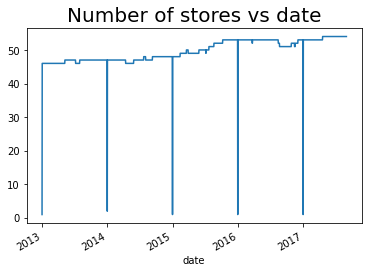

In [39]:
#39
concat_merge_df.groupby('date')['store_nbr'].nunique().plot()
plt.title("Number of stores vs date",fontsize=20)
plt.show()

- 2013年、2014年は45店舗ほどだが、2015年後半には55店舗を度に増えている。
- 1月1日はほとんどの店舗が休みである。

### 3.2 商品数と'date'(日付)を折れ線グラフでプロットして確認する

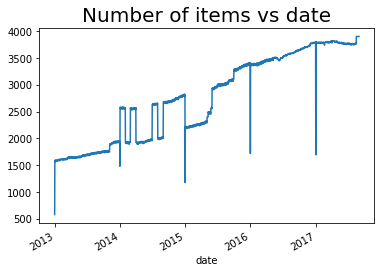

In [40]:
#40
concat_merge_df.groupby('date')['item_nbr'].nunique().plot()
plt.title("Number of items vs date",fontsize=20)
plt.show()

- 2013年前半は1500ほどだが、2017年には3700ほどに増えている。

### 3.3 'unit_sales'(指定された日付、店舗でのその商品の売上)を確認

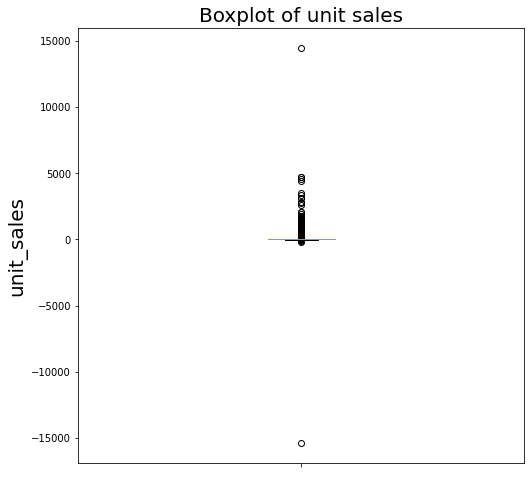

In [40]:
#41

#'unit_sales'の外れ値をボックスプロットで確認
plt.figure(figsize=(8,8))
plt.boxplot(train_merge_df['unit_sales'])
plt.title("Boxplot of unit sales",fontsize=20)
plt.ylabel('unit_sales',fontsize=20)
plt.tick_params('x', labelsize = 0)
plt.show()

'unit_sales'をボックスプロットで確認:
- 外れ値がある。全体を把握しやすくするため外れ値を取り除てグラフを作成する

In [41]:
#42

#'unit_sales'の外れ値のを除く(全てのグラフは'unit_sales'の外れ値を外す)
train_df_removed_outliers = train_merge_df[(train_merge_df['unit_sales'] < train_merge_df['unit_sales'].quantile(0.95))&\
    (train_merge_df['unit_sales'] > train_merge_df['unit_sales'].quantile(0.05))]

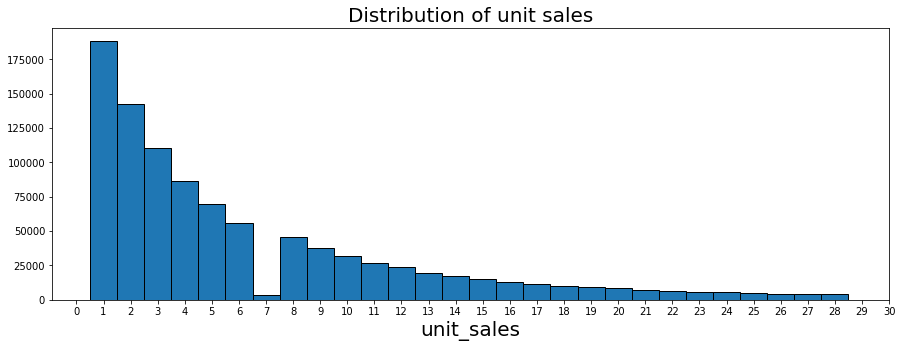

In [42]:
#43

#unit_sales'のヒストグラムを確認

plt.figure(figsize=(15,5))

plt.hist(train_df_removed_outliers['unit_sales'], bins=28, align='left', ec='black')
plt.title('Distribution of unit sales',fontsize=20)
plt.xlabel('unit_sales',fontsize=20)
plt.xticks(np.arange(0,31, step=1))
plt.show()

'unit_sales'のヒストグラムを確認：
- 1が一番高く2000万ぐらいでそれから徐々に下がっている。
- 1は$1ということである。エクアドルの通貨は、アメリカドルが使われている。
- ほとんどの商品は一日の売上が$10以下である
- エクアドルの１ヶ月の平均賃金は$500となっているため。そのことから考えるとエクアドルの$1の価値は日本で700円ぐらいの価値だと考えられる。

### 3.4 'unit_sales'と'date'(その商品の売上の日付)と'oil_dcoilwtico(石油価格)'の関係を確認

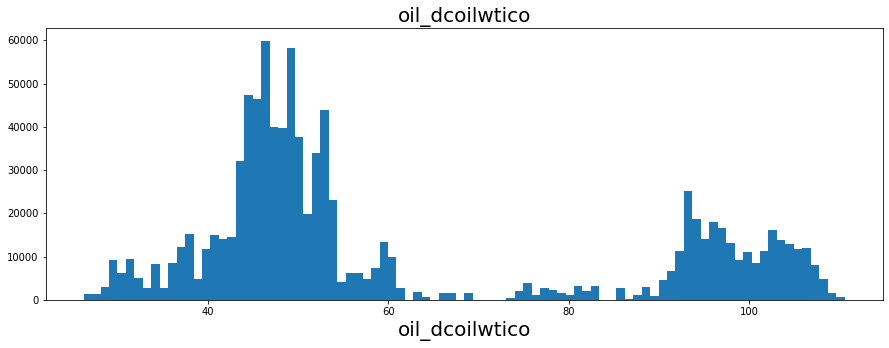

In [43]:
#44

#'oil_dcoilwtico'のヒストグラムを確認する。
plt.figure(figsize=(15,5))
plt.hist(train_df_removed_outliers['oil_dcoilwtico'], bins=90)
plt.title('oil_dcoilwtico',fontsize=20)
plt.xlabel('oil_dcoilwtico',fontsize=20)
plt.show()

'oil_dcoilwtico(石油価格)'のヒストグラムを確認する。
- 石油価格が大体60以下と90以上の2つのグループになっていることが分かる。
- それぞれのグループが売上や日付とどのように関係しているか確認する。

            oil_price  mean_sales
date                             
2013-01-01      93.14    6.456000
2013-01-02      93.14    8.977866
2013-01-03      92.97    7.717514
2013-01-04      93.12    7.719596
2013-01-05      93.20    7.976934


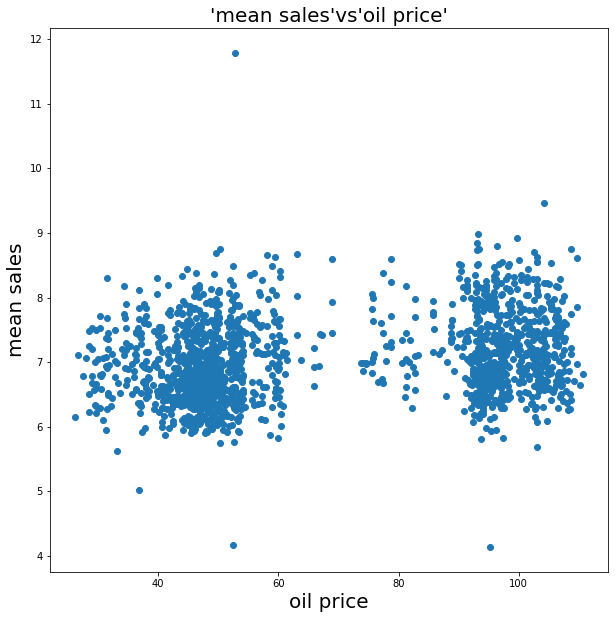

In [44]:
#45

#石油価格(oil_dcoilwtico)とその石油価格の日の商品の売上('unit_sales')の平均の関係を確認する

d = {'oil_dcoilwtico':'oil_price', 'unit_sales':'mean_sales'}
oil_and_mean_sales = train_df_removed_outliers.groupby('date').agg({'oil_dcoilwtico':'mean', 'unit_sales':'mean'}).rename(columns=d)
print(oil_and_mean_sales.head())

plt.figure(figsize=(10,10))
#train_df_removed_outliers.plot(x='trans_transactions', y='unit_sales', kind='scatter')
plt.scatter(oil_and_mean_sales['oil_price'], oil_and_mean_sales['mean_sales'])
plt.title("'mean sales'vs'oil price'",fontsize=20)
plt.xlabel('oil price',fontsize=20)
plt.ylabel('mean sales',fontsize=20)
plt.show()

石油価格(oil_dcoilwtico)とその石油価格の日の商品の売上(unit_sales)の平均の関係を確認する:
- 石油価格ではあまり商品の売上の平均は変わらない。
- 商品の売上の合計でも見てみる

            oil_price  total_sales
date                              
2013-01-01      93.14       32.280
2013-01-02      93.14     2549.714
2013-01-03      92.97     2477.322
2013-01-04      93.12     2292.720
2013-01-05      93.20     2672.273


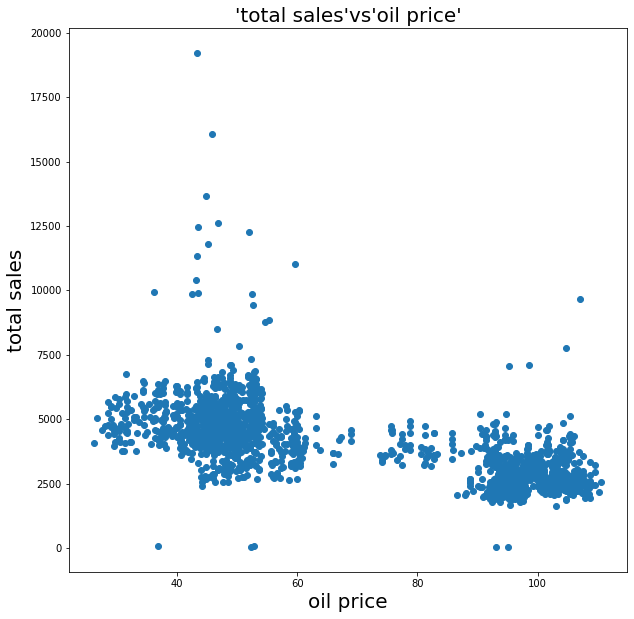

In [45]:
#46

#石油価格(oil_dcoilwtico)とその石油価格の日の商品の売上(unit_sales)の合計の関係を確認する

d = {'oil_dcoilwtico':'oil_price', 'unit_sales':'total_sales'}
oil_and_mean_sales = train_df_removed_outliers.groupby('date').agg({'oil_dcoilwtico':'mean', 'unit_sales':'sum'}).rename(columns=d)
print(oil_and_mean_sales.head())

plt.figure(figsize=(10,10))
plt.scatter(oil_and_mean_sales['oil_price'], oil_and_mean_sales['total_sales'])
plt.title("'total sales'vs'oil price'",fontsize=20)
plt.xlabel('oil price',fontsize=20)
plt.ylabel('total sales',fontsize=20)
plt.show()

#石油価格(oil_dcoilwtico)とその石油価格の日の商品の売上(unit_sales)の合計の関係を確認する:
- 石油価格ではあまり商品の売上の'平均'はあまり変わらなかったのに、商品の売上の'合計'では石油価格が安い日の方が商品の売上の合計が全体的に少し高い。
- 石油価格と売上の平均、石油価格と売上の合計を'date(日付)'を交えて比べてみる。

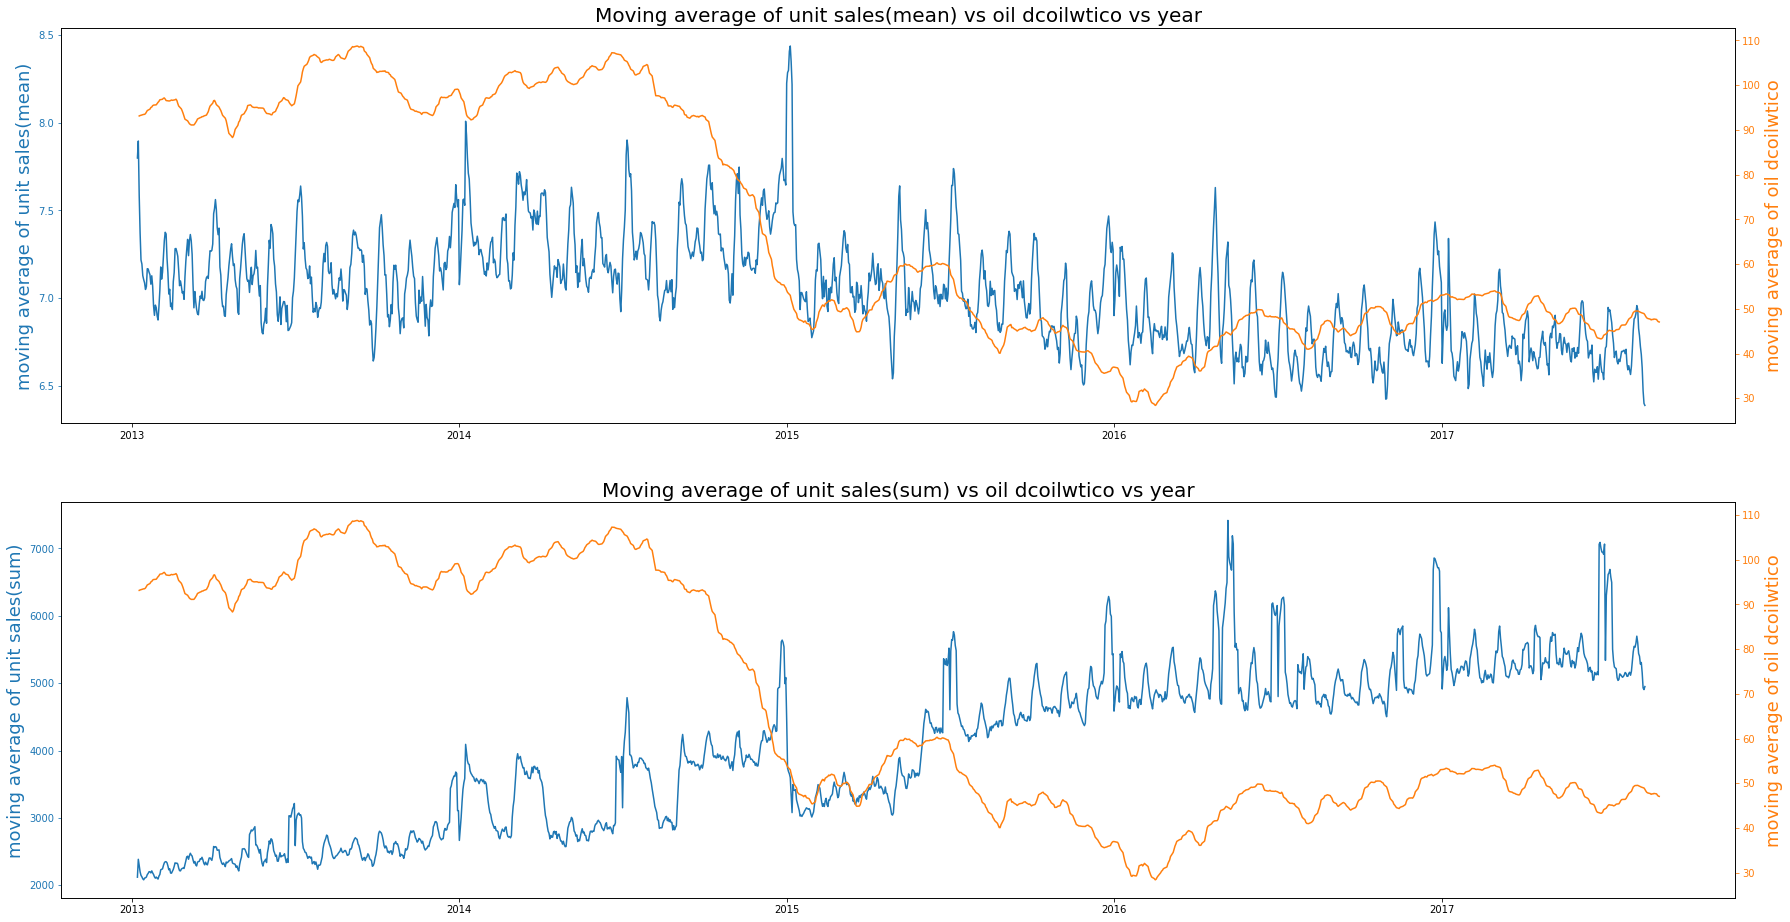

In [46]:
#47

#石油価格と売上の平均、石油価格と売上の合計を'date(日付)'を交えて比べる
fig = plt.figure(figsize=(30,16))

sals_cal_list = ['mean', 'sum']
for i,cal in enumerate(sals_cal_list):
  oil_date_df = train_df_removed_outliers.groupby('date').mean()['oil_dcoilwtico']
  if cal == 'mean':
      sales_date_df = train_df_removed_outliers.groupby('date').mean()['unit_sales']
  else:
      sales_date_df = train_df_removed_outliers.groupby('date').sum()['unit_sales']
  ax = fig.add_subplot(2, 1, i + 1)
  ax.set_title(f'Moving average of unit sales({cal}) vs oil dcoilwtico vs year',fontsize=20)
  ax.plot(sales_date_df.index, sales_date_df.rolling(7).mean(), color='C0')
  ax.set_ylabel(f'moving average of unit sales({cal})', color='C0',fontsize=18)
  ax.tick_params('y', colors='C0')
  ax_2 = ax.twinx()
  ax_2.plot(oil_df['date'], oil_df['oil_dcoilwtico'].rolling(7).mean(), color='C1')
  ax_2.set_ylabel('moving average of oil dcoilwtico', color='C1',fontsize=18)
  ax_2.tick_params('y', colors='C1')

石油価格と売上の平均、石油価格と売上の合計を'date(日付)'を交えて比べる：
- 商品の売上の合計は2014年が比較的高いように思える。
- 石油価格は2014年の後半からだいぶ落ちている。2014年の半ばは105ぐらいなのに2015年の初めには45あたりまで下がっている。
- 多少は石油価格と商品の売上は関係しているように見える。
- 商品の売上の平均は全体的に2013-2015より全体的に2015-2017の方が低いのに、商品の売上の合計は全体的に2013-2015より全体的に2015-2017の方が高い。それは2015-2017はいくつかの店舗で商品数が増えているからだと思われる。
- 日付をより細かく分けて分析してみる。

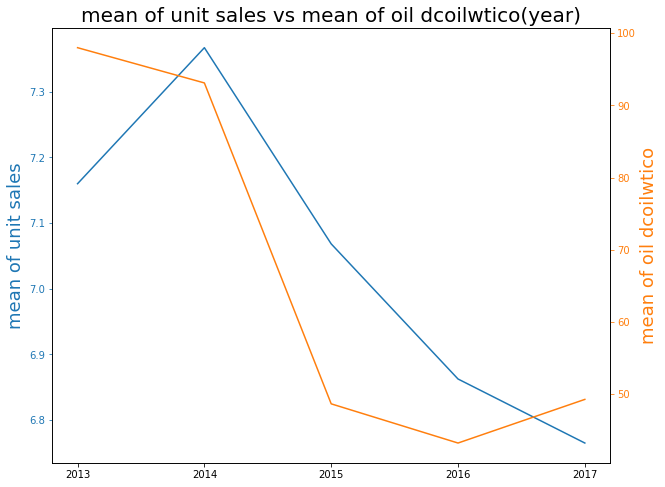

In [47]:
#48

# 目的変数'unit_sales(商品の売上)'の平均を年ごとに'oil_dcoilwtico'(石油価格)の平均と比較して価格する。

year_sales_df = train_df_removed_outliers.groupby('year').mean()['unit_sales']
year_oil_df = oil_df.groupby('year').mean()['oil_dcoilwtico']
fig, ax = plt.subplots(figsize=(10,8))
ind_str_list = []
for ind in year_sales_df.index:
     ind_str_list.append(str(ind))
ax.set_title('mean of unit sales vs mean of oil dcoilwtico(year)',fontsize=20)
ax.plot(ind_str_list, year_sales_df, color='C0')
ax.set_ylabel('mean of unit sales', color='C0',fontsize=18)
ax.tick_params('y', colors='C0')
ax_2 = ax.twinx()
ax_2.plot(ind_str_list, year_oil_df, color='C1')
ax_2.set_ylabel('mean of oil dcoilwtico', color='C1',fontsize=18)
ax_2.tick_params('y', colors='C1')
plt.show()

目的変数'unit_sales(商品の売上)'の平均を年ごとに'oil_dcoilwtico'(石油価格)の平均と比較して価格する:
- 商品の売上は2014年が高い。
- 'プロジェクトの概要'でも説明したがエクアドルは石油産業が盛んで石油価格がエクアドル経済に大きく左右されていることがこのグラフだとよく分かる。

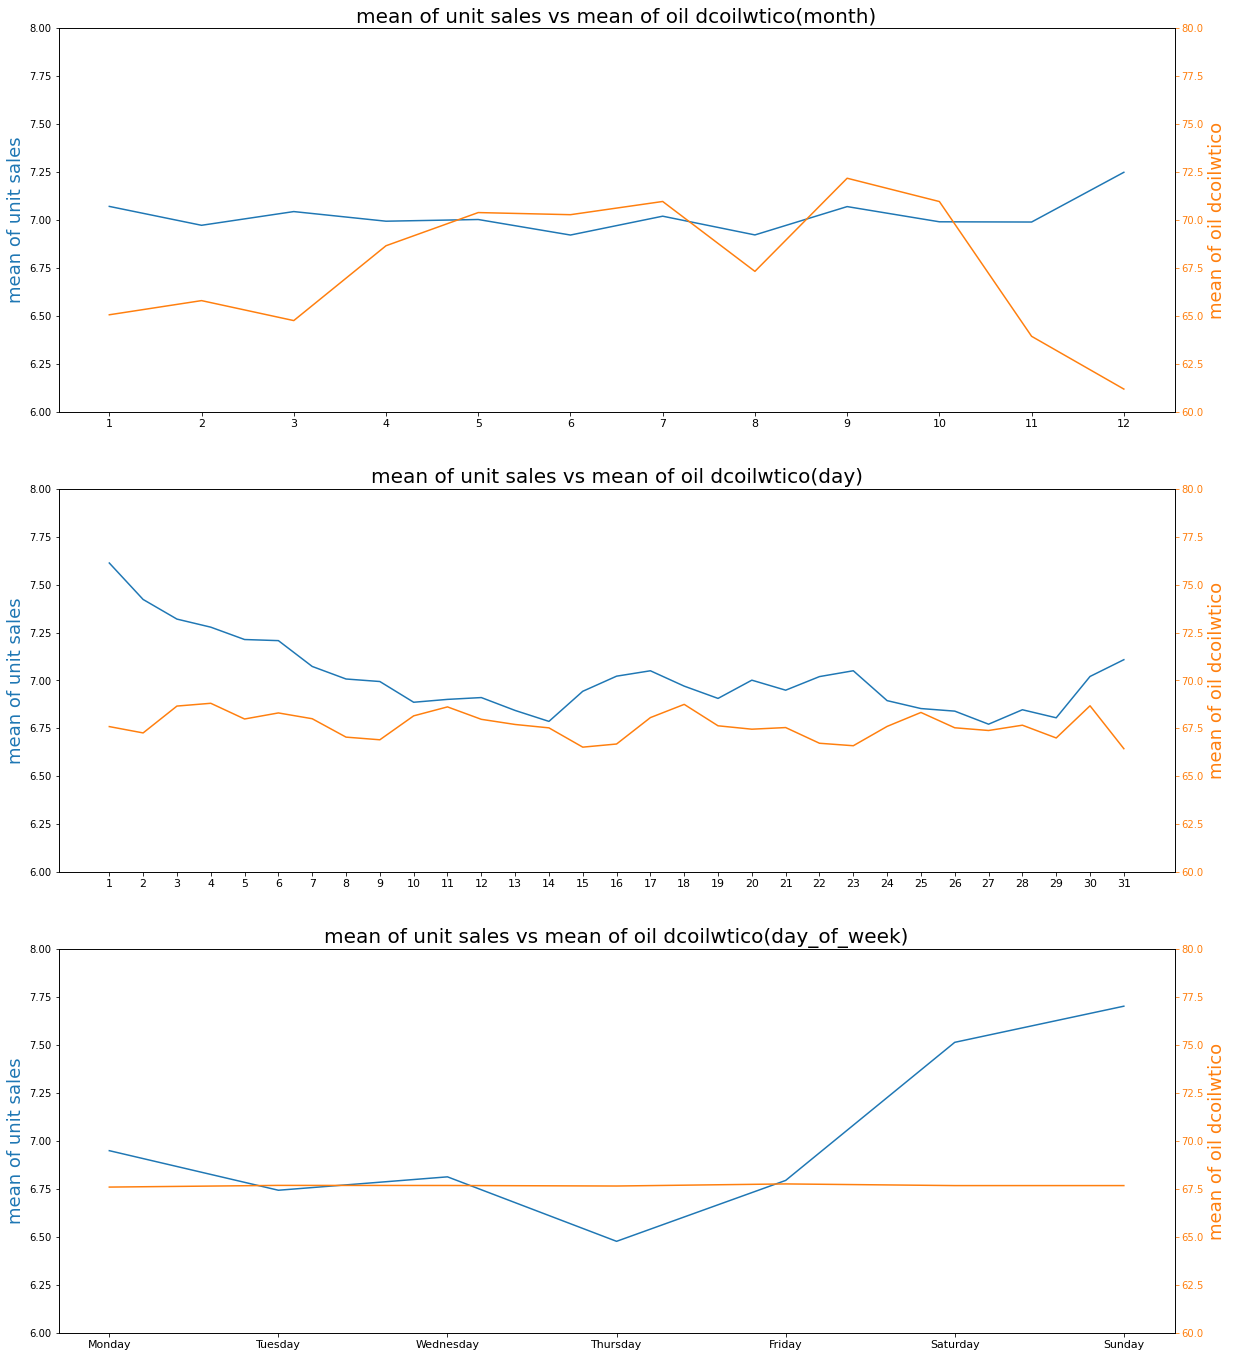

In [48]:
#49
# 目的変数'unit_sales(商品の売上)'の平均を年ごと日ごと曜日ごとに分けて確認する。

time_list = ['month', 'day', 'day_of_week']
fig = plt.figure(figsize=(20,24))

for i, time in enumerate(time_list):
    if time == 'day_of_week':
        time_sales_df = train_df_removed_outliers.groupby('day_of_week').mean()['unit_sales'].reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
        time_oil_df = oil_df.groupby('day_of_week').mean()['oil_dcoilwtico'].reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).fillna(oil_df['oil_dcoilwtico'].mean())
    else:
        time_sales_df = train_df_removed_outliers.groupby(time).mean()['unit_sales']
        time_oil_df = oil_df.groupby(time).mean()['oil_dcoilwtico']

    ind_str_list = []
    for ind in time_sales_df.index:
        ind_str_list.append(str(ind))

    ax = fig.add_subplot(3, 1, i + 1)
    ax.plot(ind_str_list, time_sales_df)
    ax.set_title('mean of unit sales vs mean of oil dcoilwtico({})'.format(time),fontsize=20)
    ax.tick_params('x', labelsize = 11)
    ax.set_ylabel('mean of unit sales', color='C0',fontsize=18)
    ax.set_ylim(6, 8)
    ax_2 = ax.twinx()
    ax_2.plot(ind_str_list, time_oil_df, color='C1')
    ax_2.set_ylabel('mean of oil dcoilwtico', color='C1',fontsize=18)
    ax_2.set_ylim(60, 80)
    ax_2.tick_params('y', colors='C1')
plt.show()

目的変数'unit_sales'の平均を年ごと日ごと曜日ごとに分けて確認する。:
- 売上が高いのは年末、月の初め、週末であることが確認できる。

### 3.5 目的変数'unit_sales(商品の売上)'と'onpromotion'(プロモーションがされていたかどうか)の関係を確認

--- Value counts of "onpromotion" ---
yes         62184
no         739958
unknown    168913
Name: onpromotion, dtype: int64


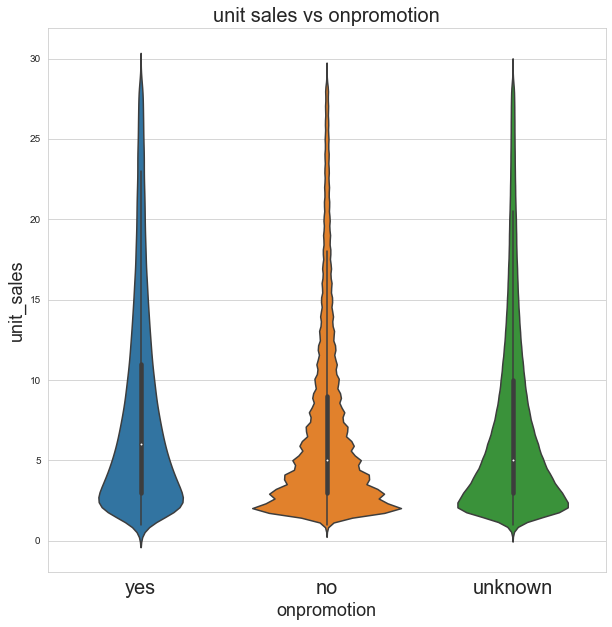

In [49]:
#50

#目的変数'unit_sales'の平均を'yes'(プロモーションがされていた), 'no'(プロモーションがされていない), 'unknown'(分からない)ごとで確認する。('unit_sales'の外れ値は削除)

print('--- Value counts of "onpromotion" ---')
order_list = ['yes', 'no','unknown']
print(train_df_removed_outliers['onpromotion'].value_counts().reindex(index=order_list))

sns.set_style("whitegrid")

plt.figure(figsize=(10,10))
sns.violinplot(data=train_df_removed_outliers, x=train_df_removed_outliers['onpromotion'], y='unit_sales', order=order_list)
plt.title("unit sales vs onpromotion",fontsize=20)
plt.xlabel('onpromotion',fontsize=18)
plt.tick_params('x', labelsize = 20)
plt.ylabel('unit_sales',fontsize=18)
plt.show()

目的変数'unit_sales(商品の売上)'の平均を'yes'(プロモーションがされていた), 'no'(プロモーションがされていない), 'unknown'(分からない)ごとで確認する。:
- やはりプロモーションをしていた商品は売上が高い。

### 3.6 目的変数'unit_sales(商品の売上)'と店舗に関する特徴量('stores_city','stores_state','stores_type','stores_cluster')との関係を確認する。
- stores_city: 町,市の名前
- stores_state: 州の名前
- stores_type: 店舗の種類
- stores_cluster: 似たような店舗を番号でグループ分けされていて、その番号

--- Value counts of "stores_city" ---
stores_city
Quito            414574
Ambato            44233
Cayambe           19720
Cuenca            54395
Daule             20250
Quevedo           15285
Babahoyo          18260
Loja              21359
Machala           35898
Guayaquil        123883
Manta             16869
Salinas           14683
Riobamba          13957
Playas             9104
Libertad          16342
Latacunga         26437
Ibarra            14908
Guaranda          13652
Esmeraldas        14445
El Carmen         12110
Santo Domingo     44274
Puyo               6417
Name: stores_city, dtype: int64


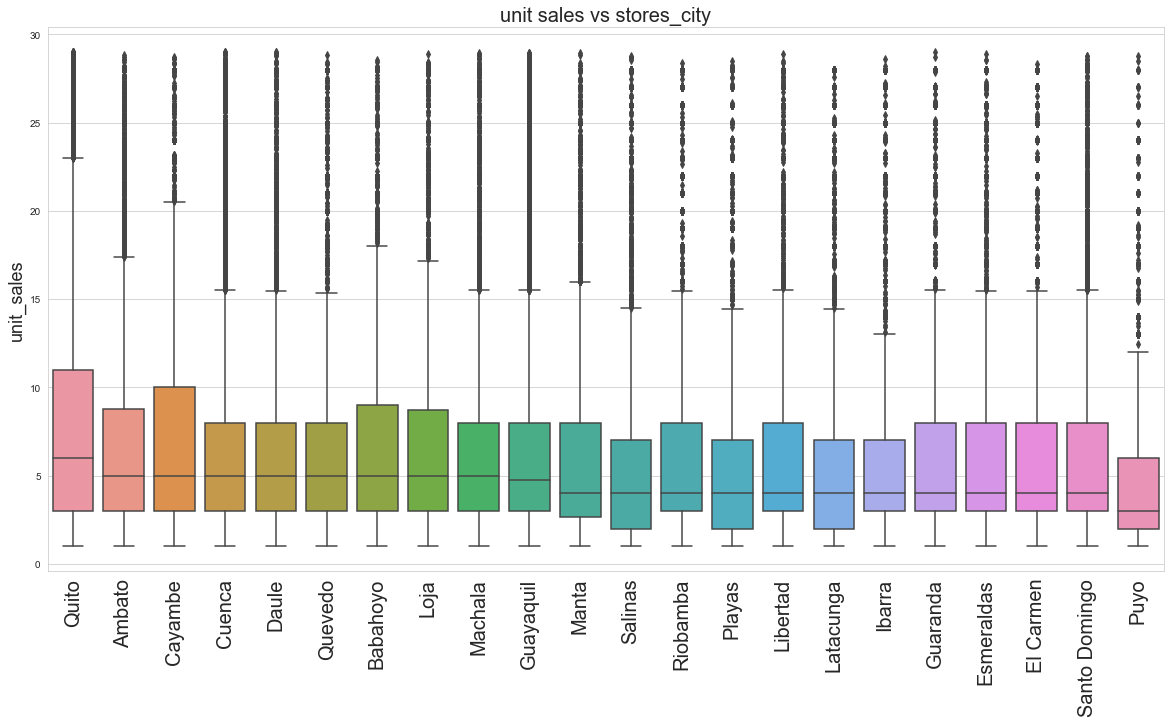

--- Value counts of "stores_state" ---
stores_state
Pichincha                         434294
Azuay                              54395
El Oro                             35898
Loja                               21359
Los Rios                           33545
Tungurahua                         44233
Bolivar                            13652
Chimborazo                         13957
Cotopaxi                           26437
Esmeraldas                         14445
Guayas                            169579
Imbabura                           14908
Manabi                             28979
Santa Elena                        14683
Santo Domingo de los Tsachilas     44274
Pastaza                             6417
Name: stores_state, dtype: int64


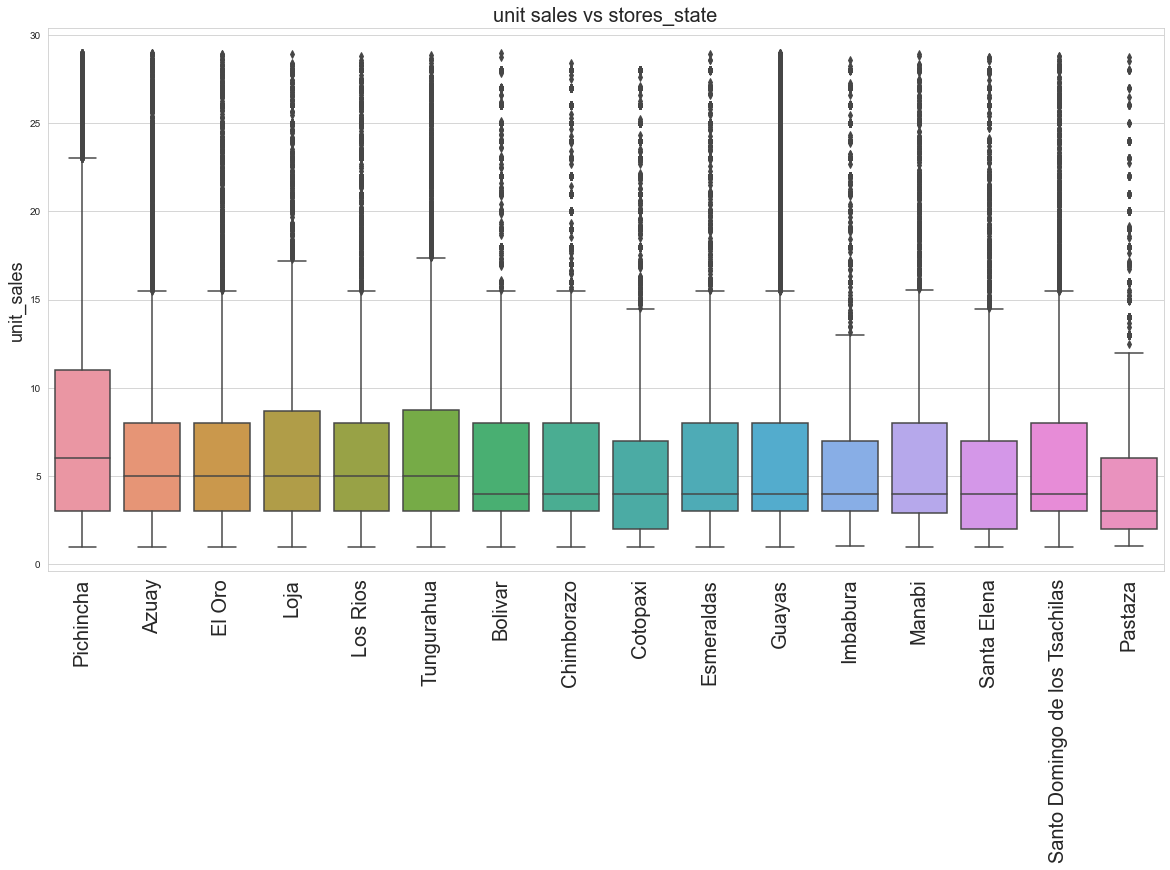

--- Value counts of "stores_type" ---
A    216110
B    138819
C    192849
D    362803
E     60474
Name: stores_type, dtype: int64


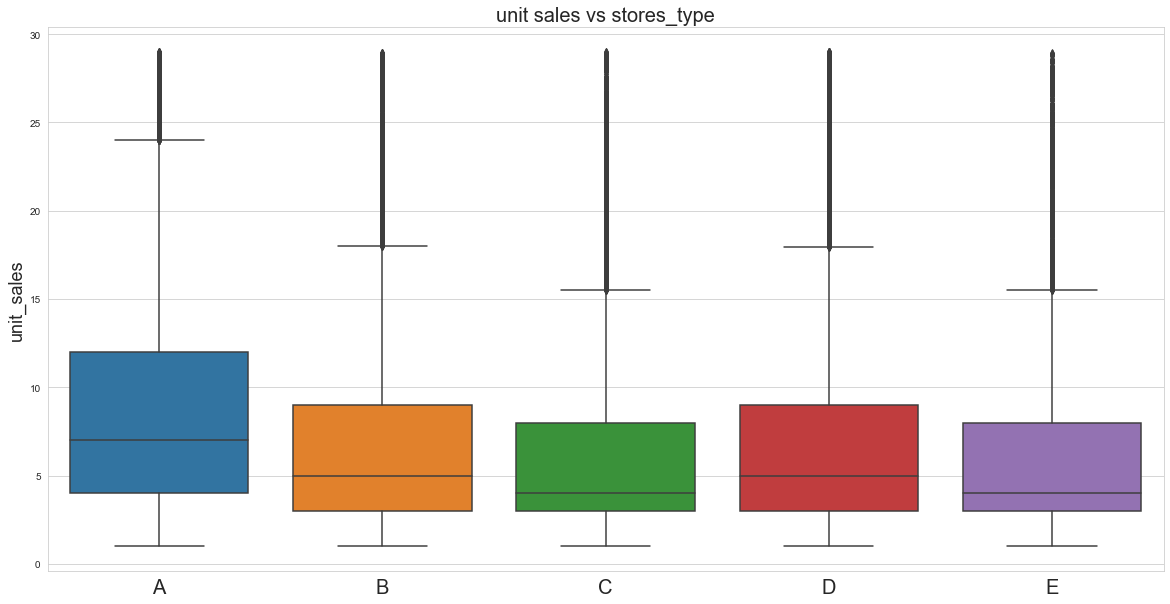

--- Value counts of "stores_cluster" ---
1      56964
2      33486
3      87088
4      60664
5      27353
6     103677
7      20374
8      76596
9      40248
10     90362
11     57045
12     17655
13     83217
14    108461
15     67732
16     16882
17     23251
Name: stores_cluster, dtype: int64


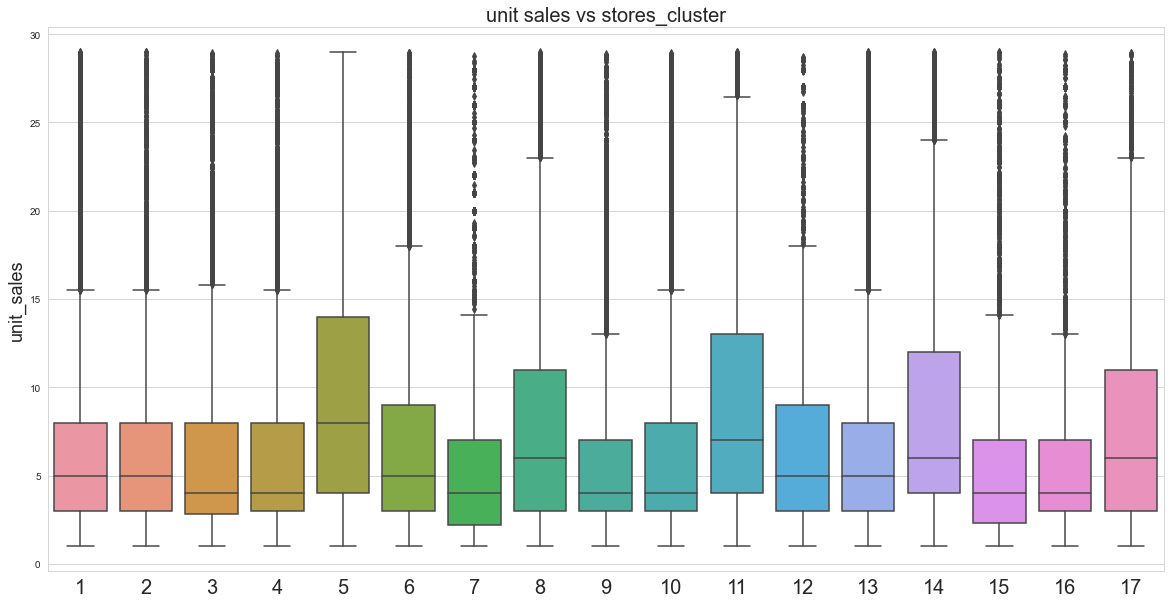

In [50]:
#51

#目的変数'unit_sales(商品の売上)'と'stores_city','stores_state','stores_type','stores_cluster(似たような店と番号でグループ分けされている)'との関係を確認する。
store_columns_list = ['stores_city','stores_state','stores_type','stores_cluster']

for store_column in store_columns_list:
    if store_column == 'stores_city' or store_column == 'stores_state':
     order_list = train_df_removed_outliers.groupby(store_column)['unit_sales'].median().sort_values(ascending=False).index
    else:
     order_list = sorted(train_df_removed_outliers[store_column].unique())
    
    print(f'--- Value counts of "{store_column}" ---')
    print(train_df_removed_outliers[store_column].value_counts().reindex(index=order_list))
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot()
    sns.boxplot(data=train_df_removed_outliers, x=store_column, y='unit_sales', ax=ax, order=order_list)
    ax.set_title(f'unit sales vs {store_column}',fontsize=20)
    if store_column == 'stores_city' or store_column == 'stores_state':
      ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    ax.tick_params('x', labelsize = 20)
    ax.set_xlabel('', fontsize = 0)
    ax.set_ylabel('unit_sales', fontsize = 18)
    plt.subplots_adjust(hspace=0.6)
    plt.show()

目的変数'unit_sales(商品の売上)'と'stores_city','stores_state','stores_type','stores_cluster(似たような店でのグループ)'との関係を確認する。):
- 'unit sales vs stores_type': Aが明らかに高いのが確認できる。
- 'unit sales vs stores_cluster(似たような店でのグループ)': 5が明らかに高いのが確認できる。
- 'stores_type'と'stores_cluster'は売上と相関があると思われるので、'stores_type'と'stores_cluster'を掛け合わせた変数で売上との関係を確認する

--- Value counts of "stores type and cluster" ---
A11     57045
A14    108461
A17     23251
A5      27353
B10     18260
B16     16882
B6     103677
C12     17655
C15     67732
C3      87088
C7      20374
D1      56964
D10     11628
D13     83217
D2      33486
D4      60664
D8      76596
D9      40248
E10     60474
Name: stores_type_and_cluster, dtype: int64


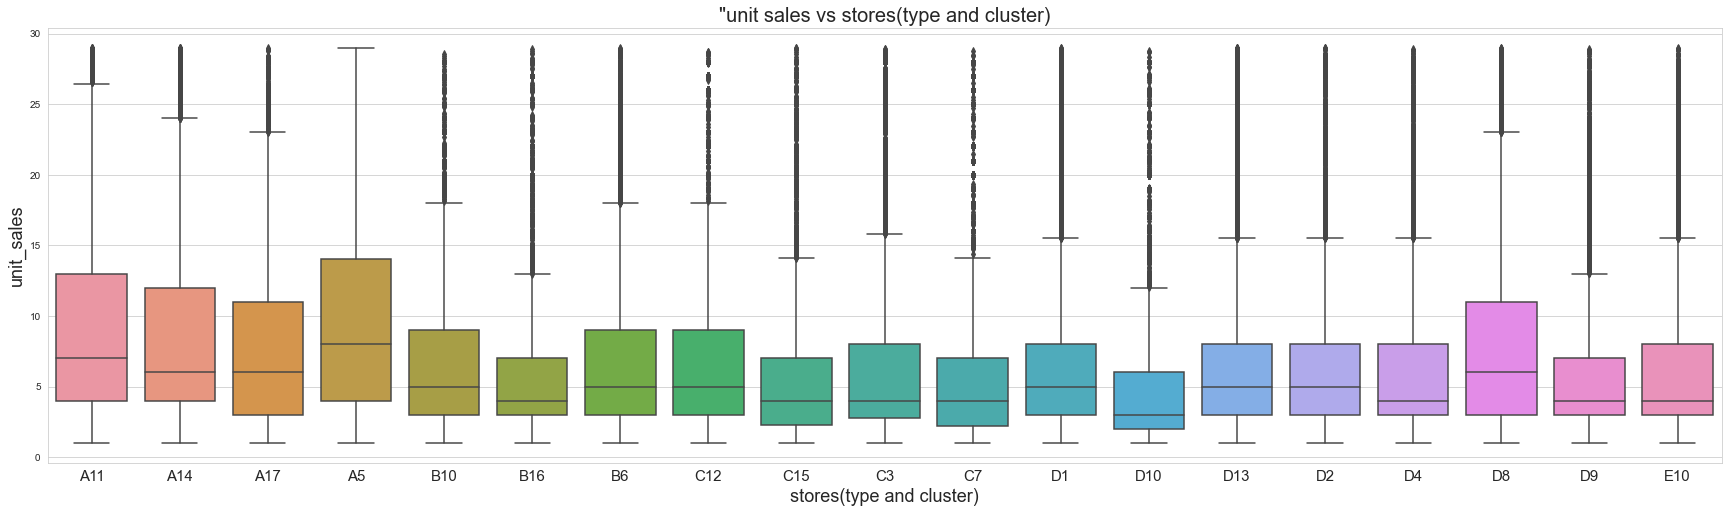

In [51]:
#52

#'stores_type'と'stores_cluster'を組み合わせて目的変数'unit_sales(商品の売上)'との関係を確認する。
stores_type_and_cluster = []
for n in range(train_df_removed_outliers.shape[0]):
    stores_type = train_df_removed_outliers['stores_type'].iloc[n]
    stores_cluster = train_df_removed_outliers['stores_cluster'].iloc[n]
    stores_type_and_cluster.append("{}{}".format(stores_type, stores_cluster))
train_df_removed_outliers['stores_type_and_cluster'] = stores_type_and_cluster

order_list = sorted(train_df_removed_outliers['stores_type_and_cluster'].unique())

print('--- Value counts of "stores type and cluster" ---')
print(train_df_removed_outliers['stores_type_and_cluster'].value_counts().reindex(index=order_list))

fig = plt.figure(figsize=(30,8))
ax = fig.add_subplot()
sns.boxplot(data=train_df_removed_outliers, x='stores_type_and_cluster', y='unit_sales', order=order_list, ax=ax)
ax.set_title('"unit sales vs stores(type and cluster)',fontsize=20)
ax.tick_params('x', labelsize = 15)
ax.set_ylabel('unit_sales', fontsize = 18)
ax.set_xlabel('stores(type and cluster)', fontsize = 18)  
plt.show()

'stores_type'と'stores_cluster'を組み合わせて目的変数'unit_sales(商品の売上)'との関係を確認する。：
- Aの中でもA5が比較的高い。
- 'stores_cluster'はすべての'stores_type'に割り振られているわけでわない、例えば11,14,17,5はAにしかなく、10はB,D,Eにある。
- 'stores_type'と'stores_cluster'を組み合わせは売上に関係しているように思われる。

### 3.7 目的変数'unit_sales(商品の売上)'と商品に関する特徴量('items_family','items_class','items_perishable')との関係を確認する。
- items_family: 商品の種類(FROZEN FOODS,HOME CARE,BEVERAGES, など)
- items_class: クラス
- items_perishable: 腐りやすいかどうか(0,又は1)

--- Value counts of "items_family" ---
items_family
POULTRY                        14293
PRODUCE                        56938
PREPARED FOODS                  6195
SEAFOOD                         2169
BREAD/BAKERY                   38303
EGGS                           13015
BEVERAGES                     133753
MEATS                          21053
DAIRY                          74223
LIQUOR,WINE,BEER                7329
FROZEN FOODS                   11897
GROCERY I                     353807
GROCERY II                      2167
CLEANING                      131511
DELI                           32377
PERSONAL CARE                  32509
HOME CARE                      22728
SCHOOL AND OFFICE SUPPLIES       309
PLAYERS AND ELECTRONICS         1289
PET SUPPLIES                     771
MAGAZINES                        548
HOME AND KITCHEN II             2459
LINGERIE                        1549
LAWN AND GARDEN                 1030
LADIESWEAR                      1565
HOME AND KITCHEN I     

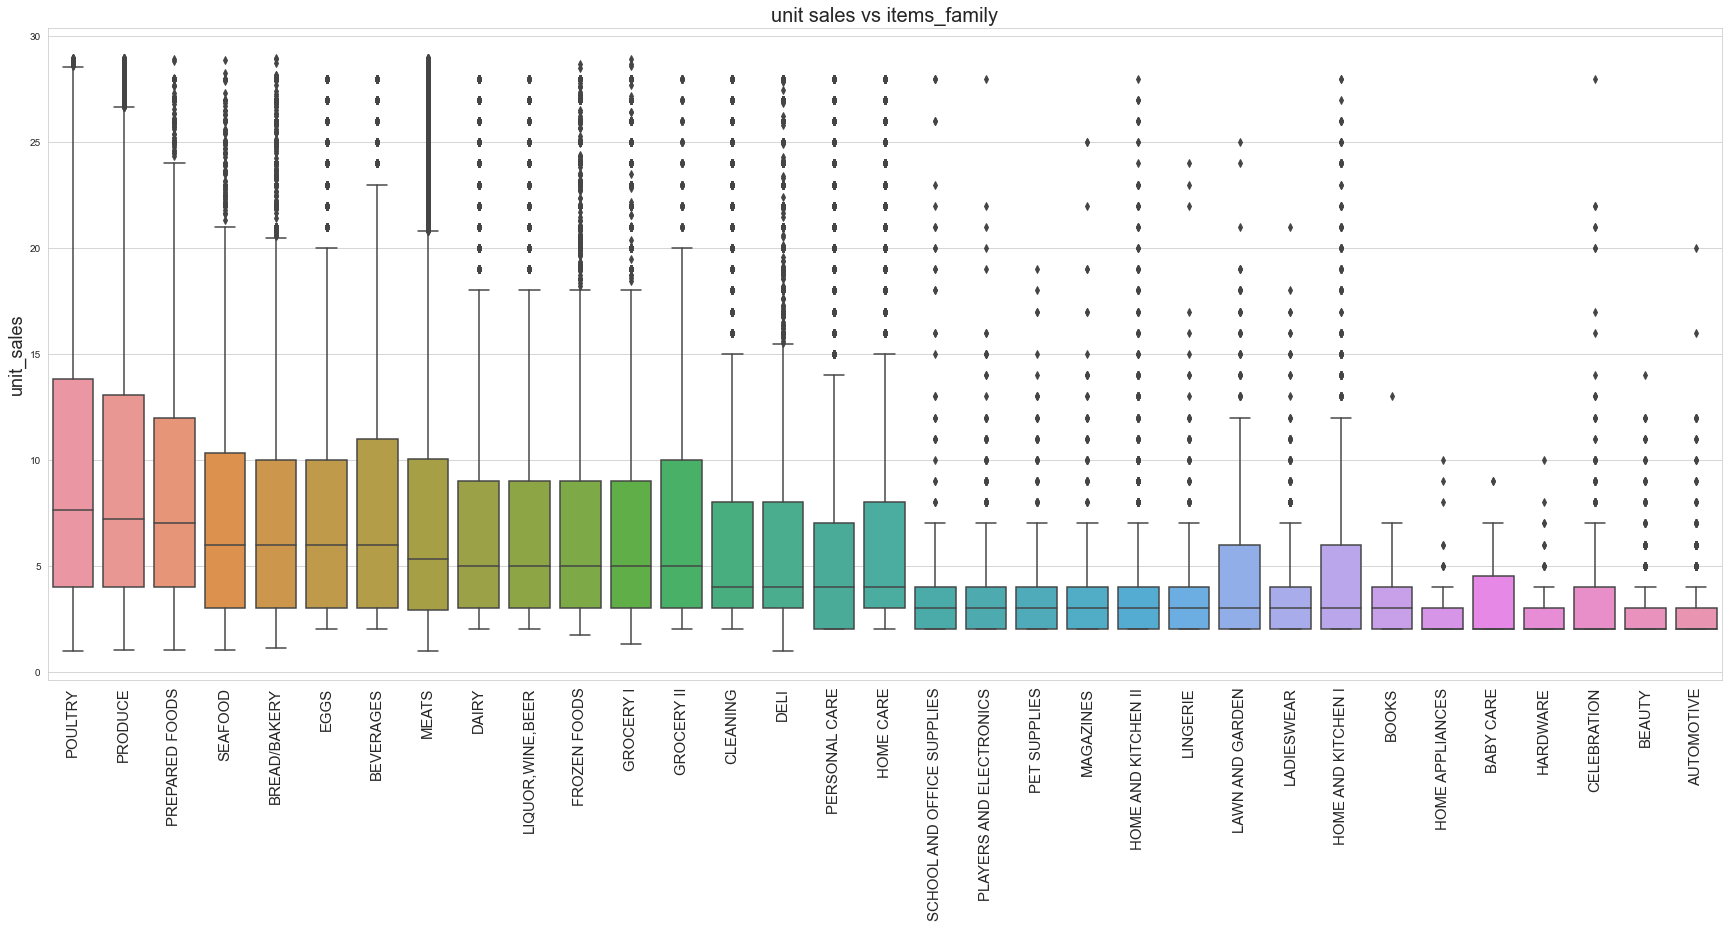

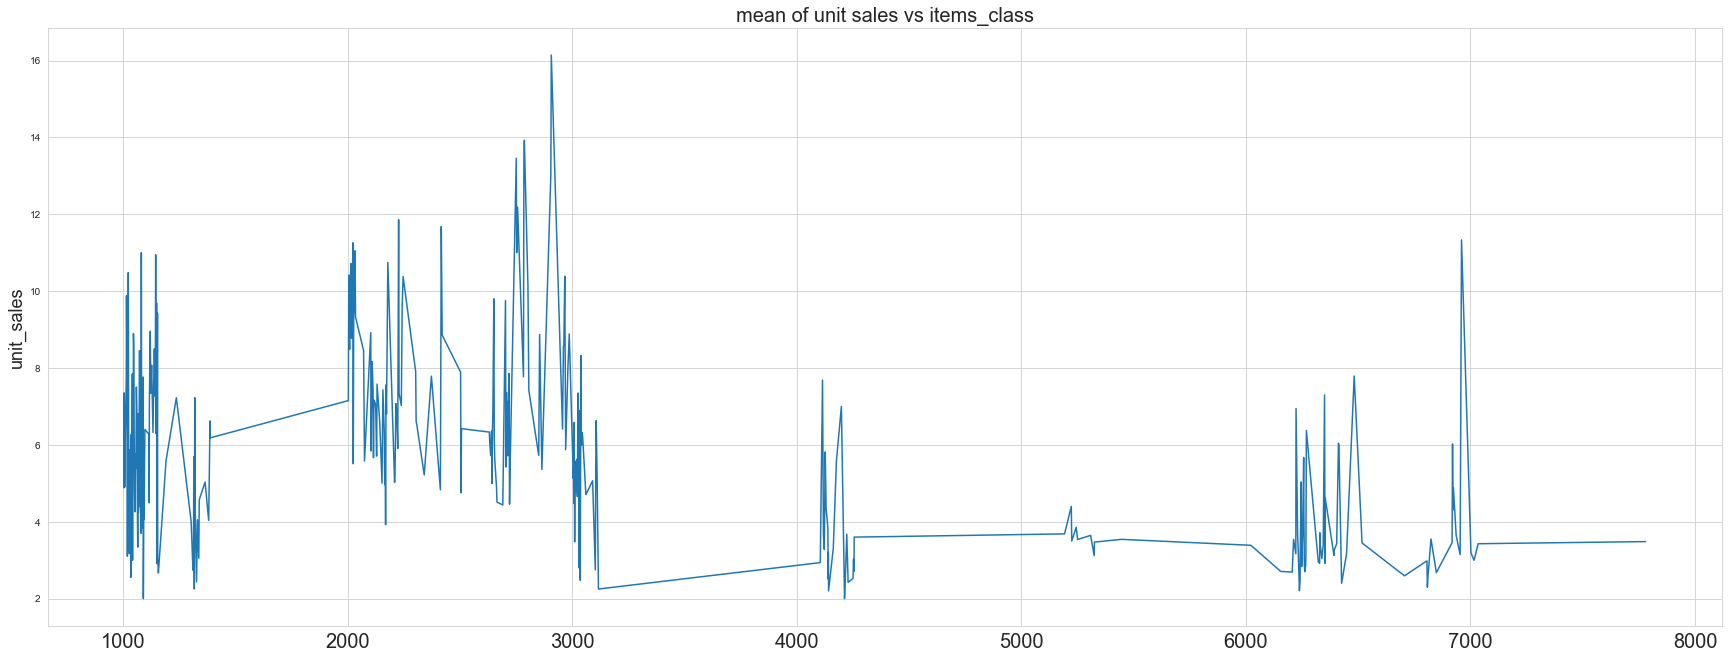

--- Value counts of "items_perishable" ---
0    712489
1    258566
Name: items_perishable, dtype: int64


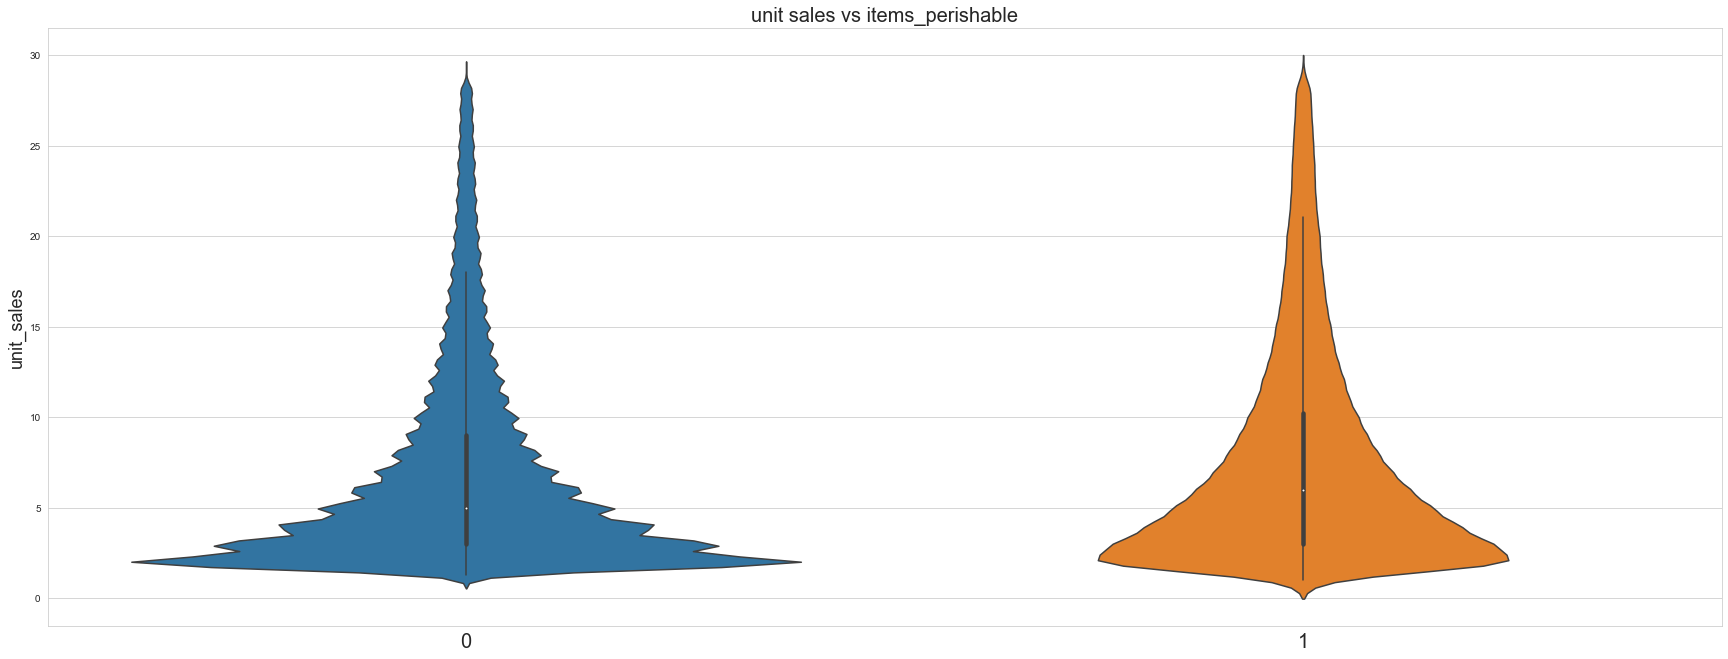

In [52]:
#53

#目的変数'unit_sales'と商品に関する特徴量('items_family','items_class','items_perishable')との関係を確認する。('unit_sales'の外れ値は削除)
order_list = train_df_removed_outliers.groupby('items_family')['unit_sales'].median().sort_values(ascending=False).index
print('--- Value counts of "items_family" ---')
print(train_df_removed_outliers['items_family'].value_counts().reindex(index=order_list))

plt.figure(figsize=(30,12))
sns.set_style("whitegrid")
sns.boxplot(data=train_df_removed_outliers, x='items_family', y='unit_sales', order=order_list)
plt.xticks(rotation =90)
plt.title("unit sales vs items_family",fontsize=20)
plt.tick_params('x', labelsize = 15)
plt.xlabel('', fontsize = 0)
plt.ylabel('unit_sales', fontsize = 18)
plt.show()

item_columns_list = ['items_class','items_perishable']

for item_column in item_columns_list:
    fig = plt.figure(figsize=(30,11))
    if item_column == 'items_class':
      ax = fig.add_subplot()
      train_df_removed_outliers.groupby('items_class').mean()['unit_sales'].plot()
      ax.set_title('mean of unit sales vs {}'.format(item_column),fontsize=20)
    else:
      print('--- Value counts of "items_perishable" ---')
      print(train_df_removed_outliers['items_perishable'].value_counts().sort_index())
      ax = fig.add_subplot()
      sns.violinplot(data=train_df_removed_outliers, x='items_perishable', y='unit_sales', ax=ax)
      ax.set_title('unit sales vs {}'.format(item_column),fontsize=20)
    ax.tick_params('x', labelsize = 20)
    ax.set_xlabel('', fontsize = 0)
    ax.set_ylabel('unit_sales', fontsize = 18)
    plt.show()


目的変数'unit_sales'と商品に関する特徴量('items_family','items_class','items_perishable')との関係を確認する:
- unit sales vs items_family(商品の種類): やはりスーパーなので野菜、卵、肉、パンなどは売上が高くてコスメや赤ちゃん用品、本などは低い。
- unit sales vs items_class(クラス): クラスが何を示してるのかよく分からないが、少しは売上に関係してることがわかる。
- unit sales vs items_perishable(腐りやすいかどうか): 1(腐りやすい商品)の方が中央値は少し高い肉や魚などはよく売れると思われる、0(腐りにくい又は腐らない商品)は売上が低い商品が多いと思われる。

### 3.8 'items_class'と'item_nbr'の数量を比べる。

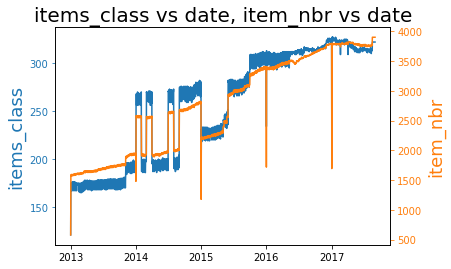

In [41]:
#54
items_nunique = concat_merge_df[['date', 'items_class', 'item_nbr']].groupby('date').nunique()

fig, ax = plt.subplots()
ax.set_title('items_class vs date, item_nbr vs date',fontsize=20)
ax.plot(items_nunique.index, items_nunique['items_class'], color='C0')
ax.set_ylabel('items_class', color='C0',fontsize=18)
ax.tick_params('y', colors='C0')
ax_2 = ax.twinx()
ax_2.plot(items_nunique.index, items_nunique['item_nbr'], color='C1')
ax_2.set_ylabel('item_nbr', color='C1',fontsize=18)
ax_2.tick_params('y', colors='C1')
plt.show()

- 'items_class'と'item_nbr'の数量は違うが増え方は似ているので、関係があると思われる。

'items_class'と'items_family'の関係を確認する。

In [42]:
#55
items_class_under_2000 = concat_merge_df[concat_merge_df['items_class'] < 2000]
items_class_2000_to_3000 = concat_merge_df[(concat_merge_df['items_class'] >= 2000) & (concat_merge_df['items_class'] < 3000)]
items_class_3000_to_4000 = concat_merge_df[(concat_merge_df['items_class'] >= 3000) & (concat_merge_df['items_class'] < 4000)]
items_class_4000_to_5000 = concat_merge_df[(concat_merge_df['items_class'] >= 4000) & (concat_merge_df['items_class'] < 5000)]
items_class_5000_to_6000 = concat_merge_df[(concat_merge_df['items_class'] >= 5000) & (concat_merge_df['items_class'] < 6000)]
items_class_6000_to_7000 = concat_merge_df[(concat_merge_df['items_class'] >= 6000) & (concat_merge_df['items_class'] < 7000)]
items_class_over_7000 = concat_merge_df[concat_merge_df['items_class'] >= 7000]

In [43]:
#56
items_class_list = [items_class_under_2000, items_class_2000_to_3000, items_class_3000_to_4000, items_class_4000_to_5000, items_class_5000_to_6000, items_class_6000_to_7000, items_class_over_7000]

In [44]:
#57
items_class_str_list = ['items_class_under_2000', 'items_class_2000_to_3000', 'items_class_3000_to_4000', 'items_class_4000_to_5000', 'items_class_5000_to_6000', 'items_class_6000_to_7000', 'items_class_over_7000']

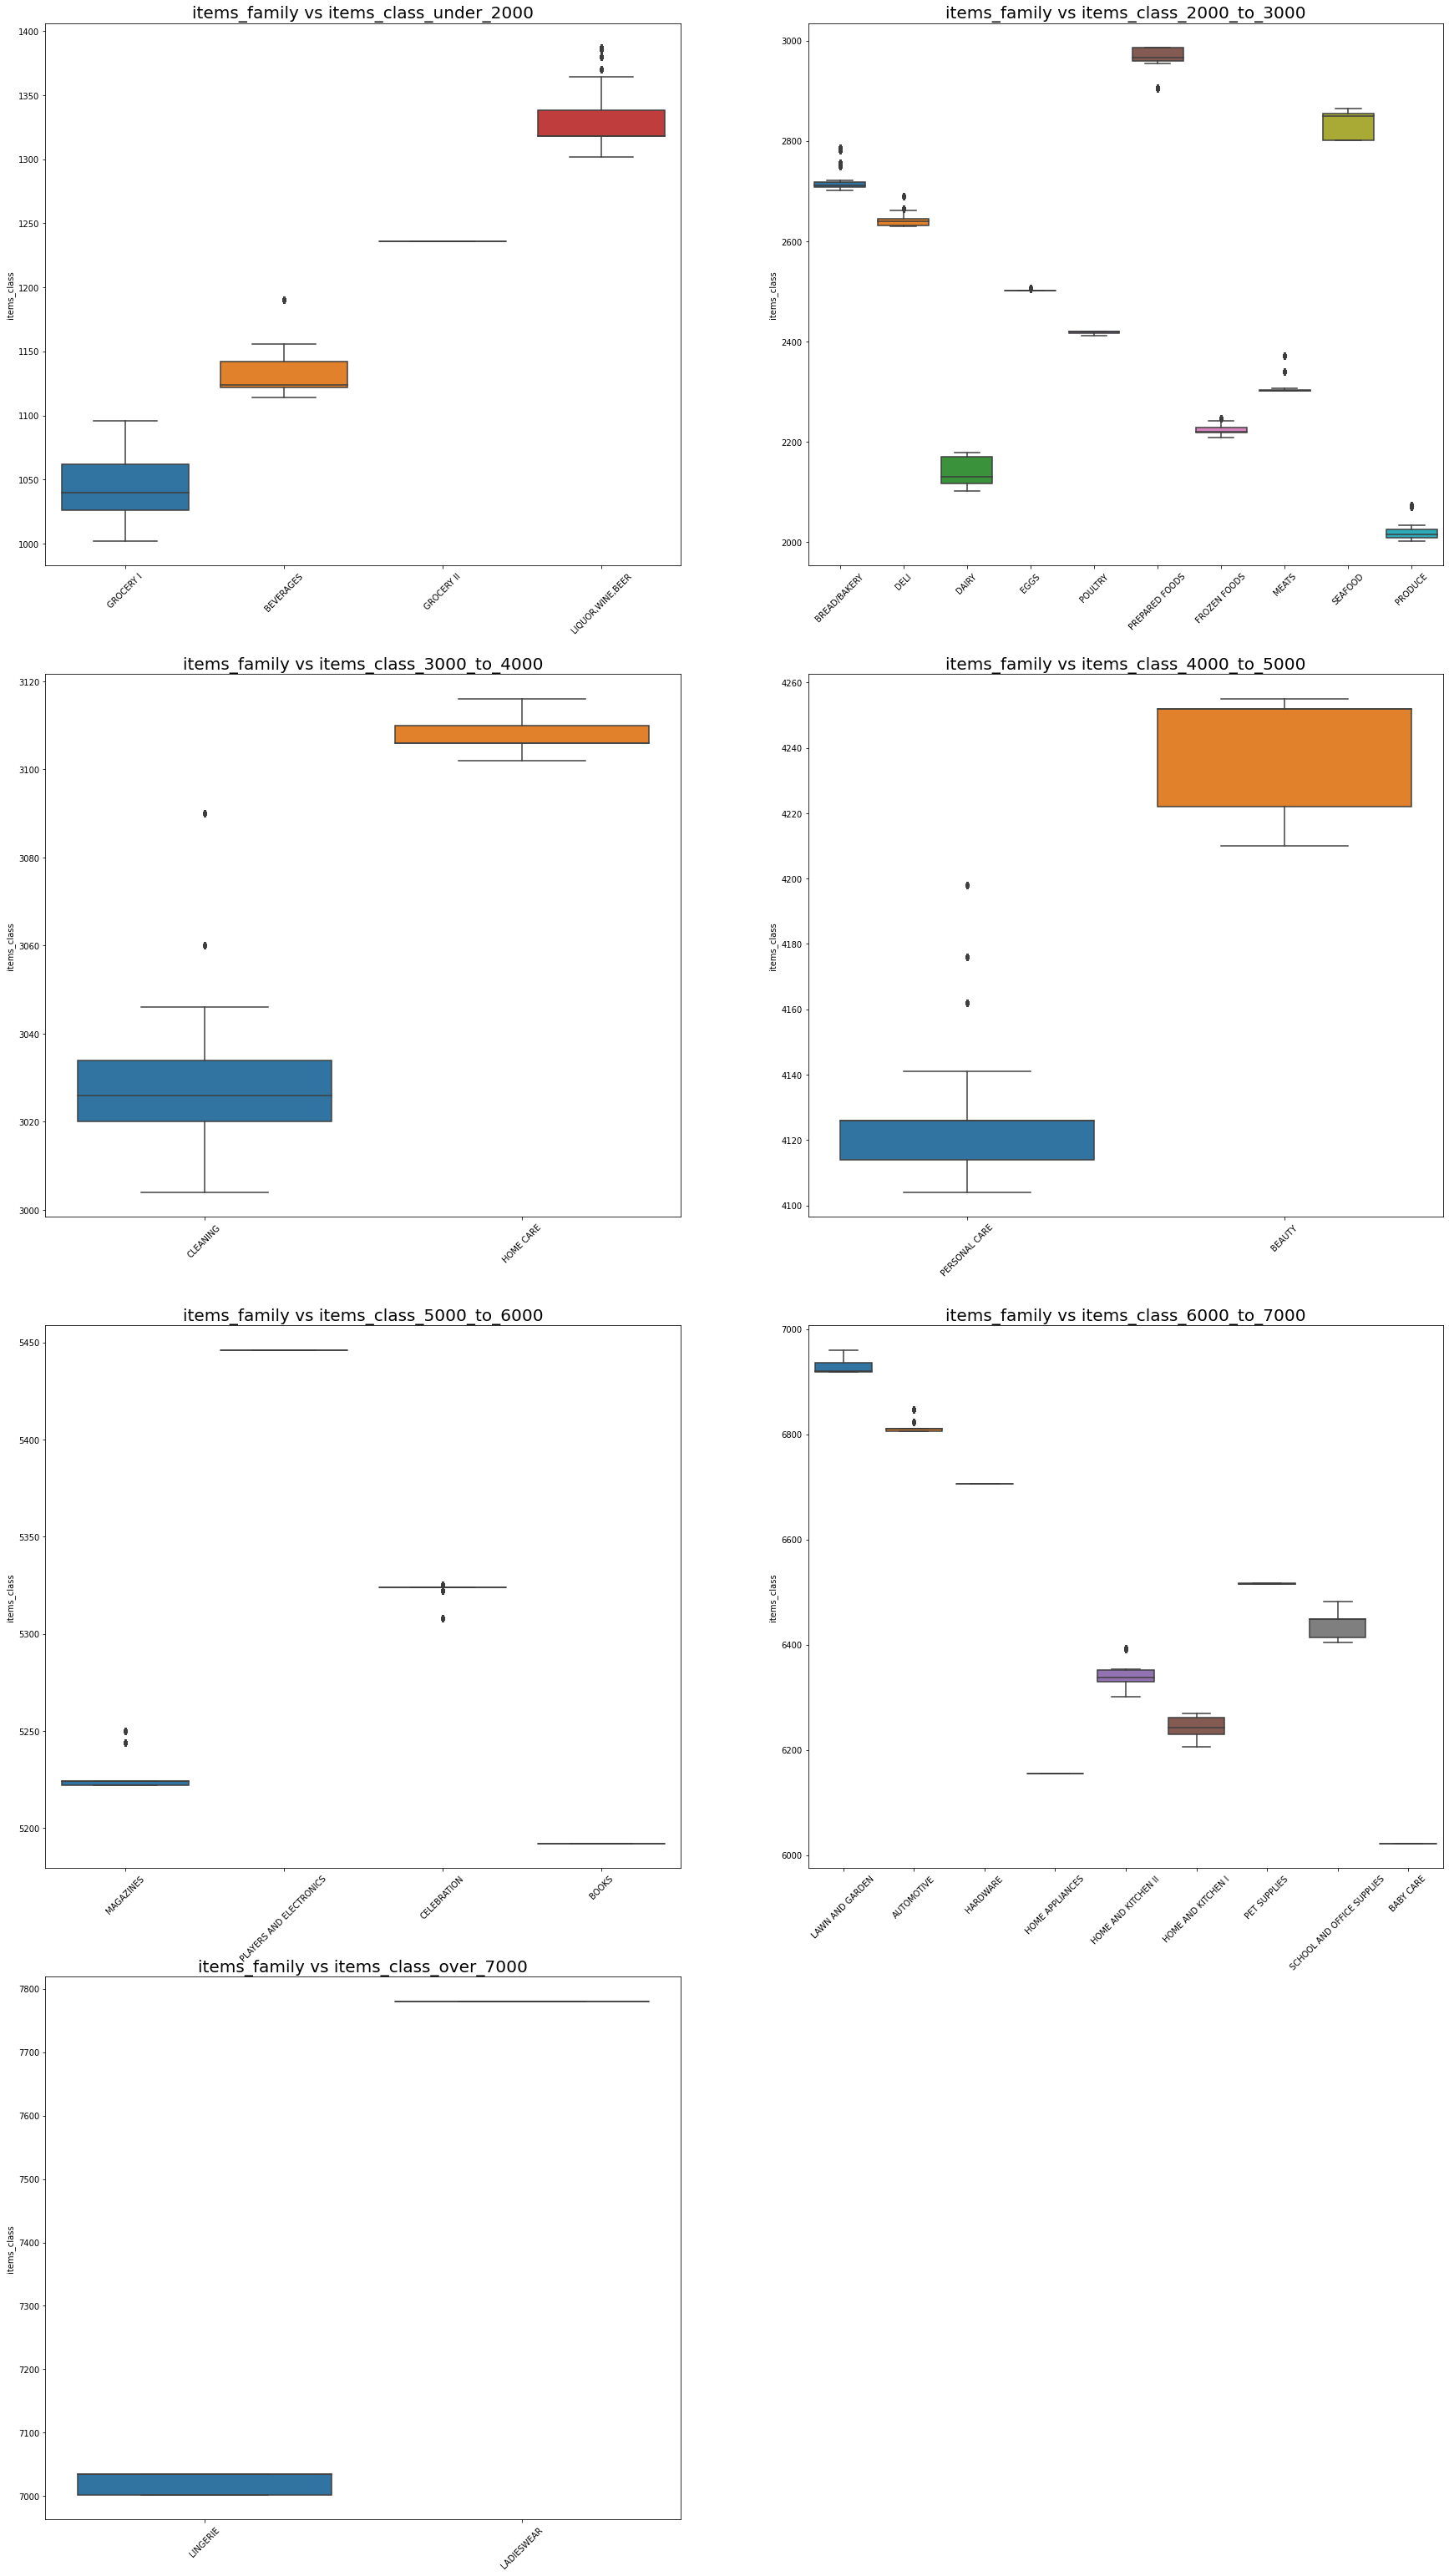

In [45]:
#58
fig = plt.figure(figsize=(30,55))
for i,items_class_category in enumerate(items_class_list):
    ax = fig.add_subplot(4,2,i+1)
    ax.set_title(f'items_family vs {items_class_str_list[i]}',fontsize=20)
    sns.boxplot(x="items_family", y="items_class", data=items_class_category, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
    ax.tick_params('x', labelsize = 10)
    ax.set_xlabel('', fontsize = 0)  
plt.show()

- 商品の種類ごとに番号が割り当てられていることが確認できる。
- 1000 ~ 3000はGROCERY1、EGGS(卵), MEATS(肉)などの食べ物で、3000 ~ 8000はCLEANING(掃除用品), BEAUTY(コスメ), BOOKS(本)など食べ物以外のものである。

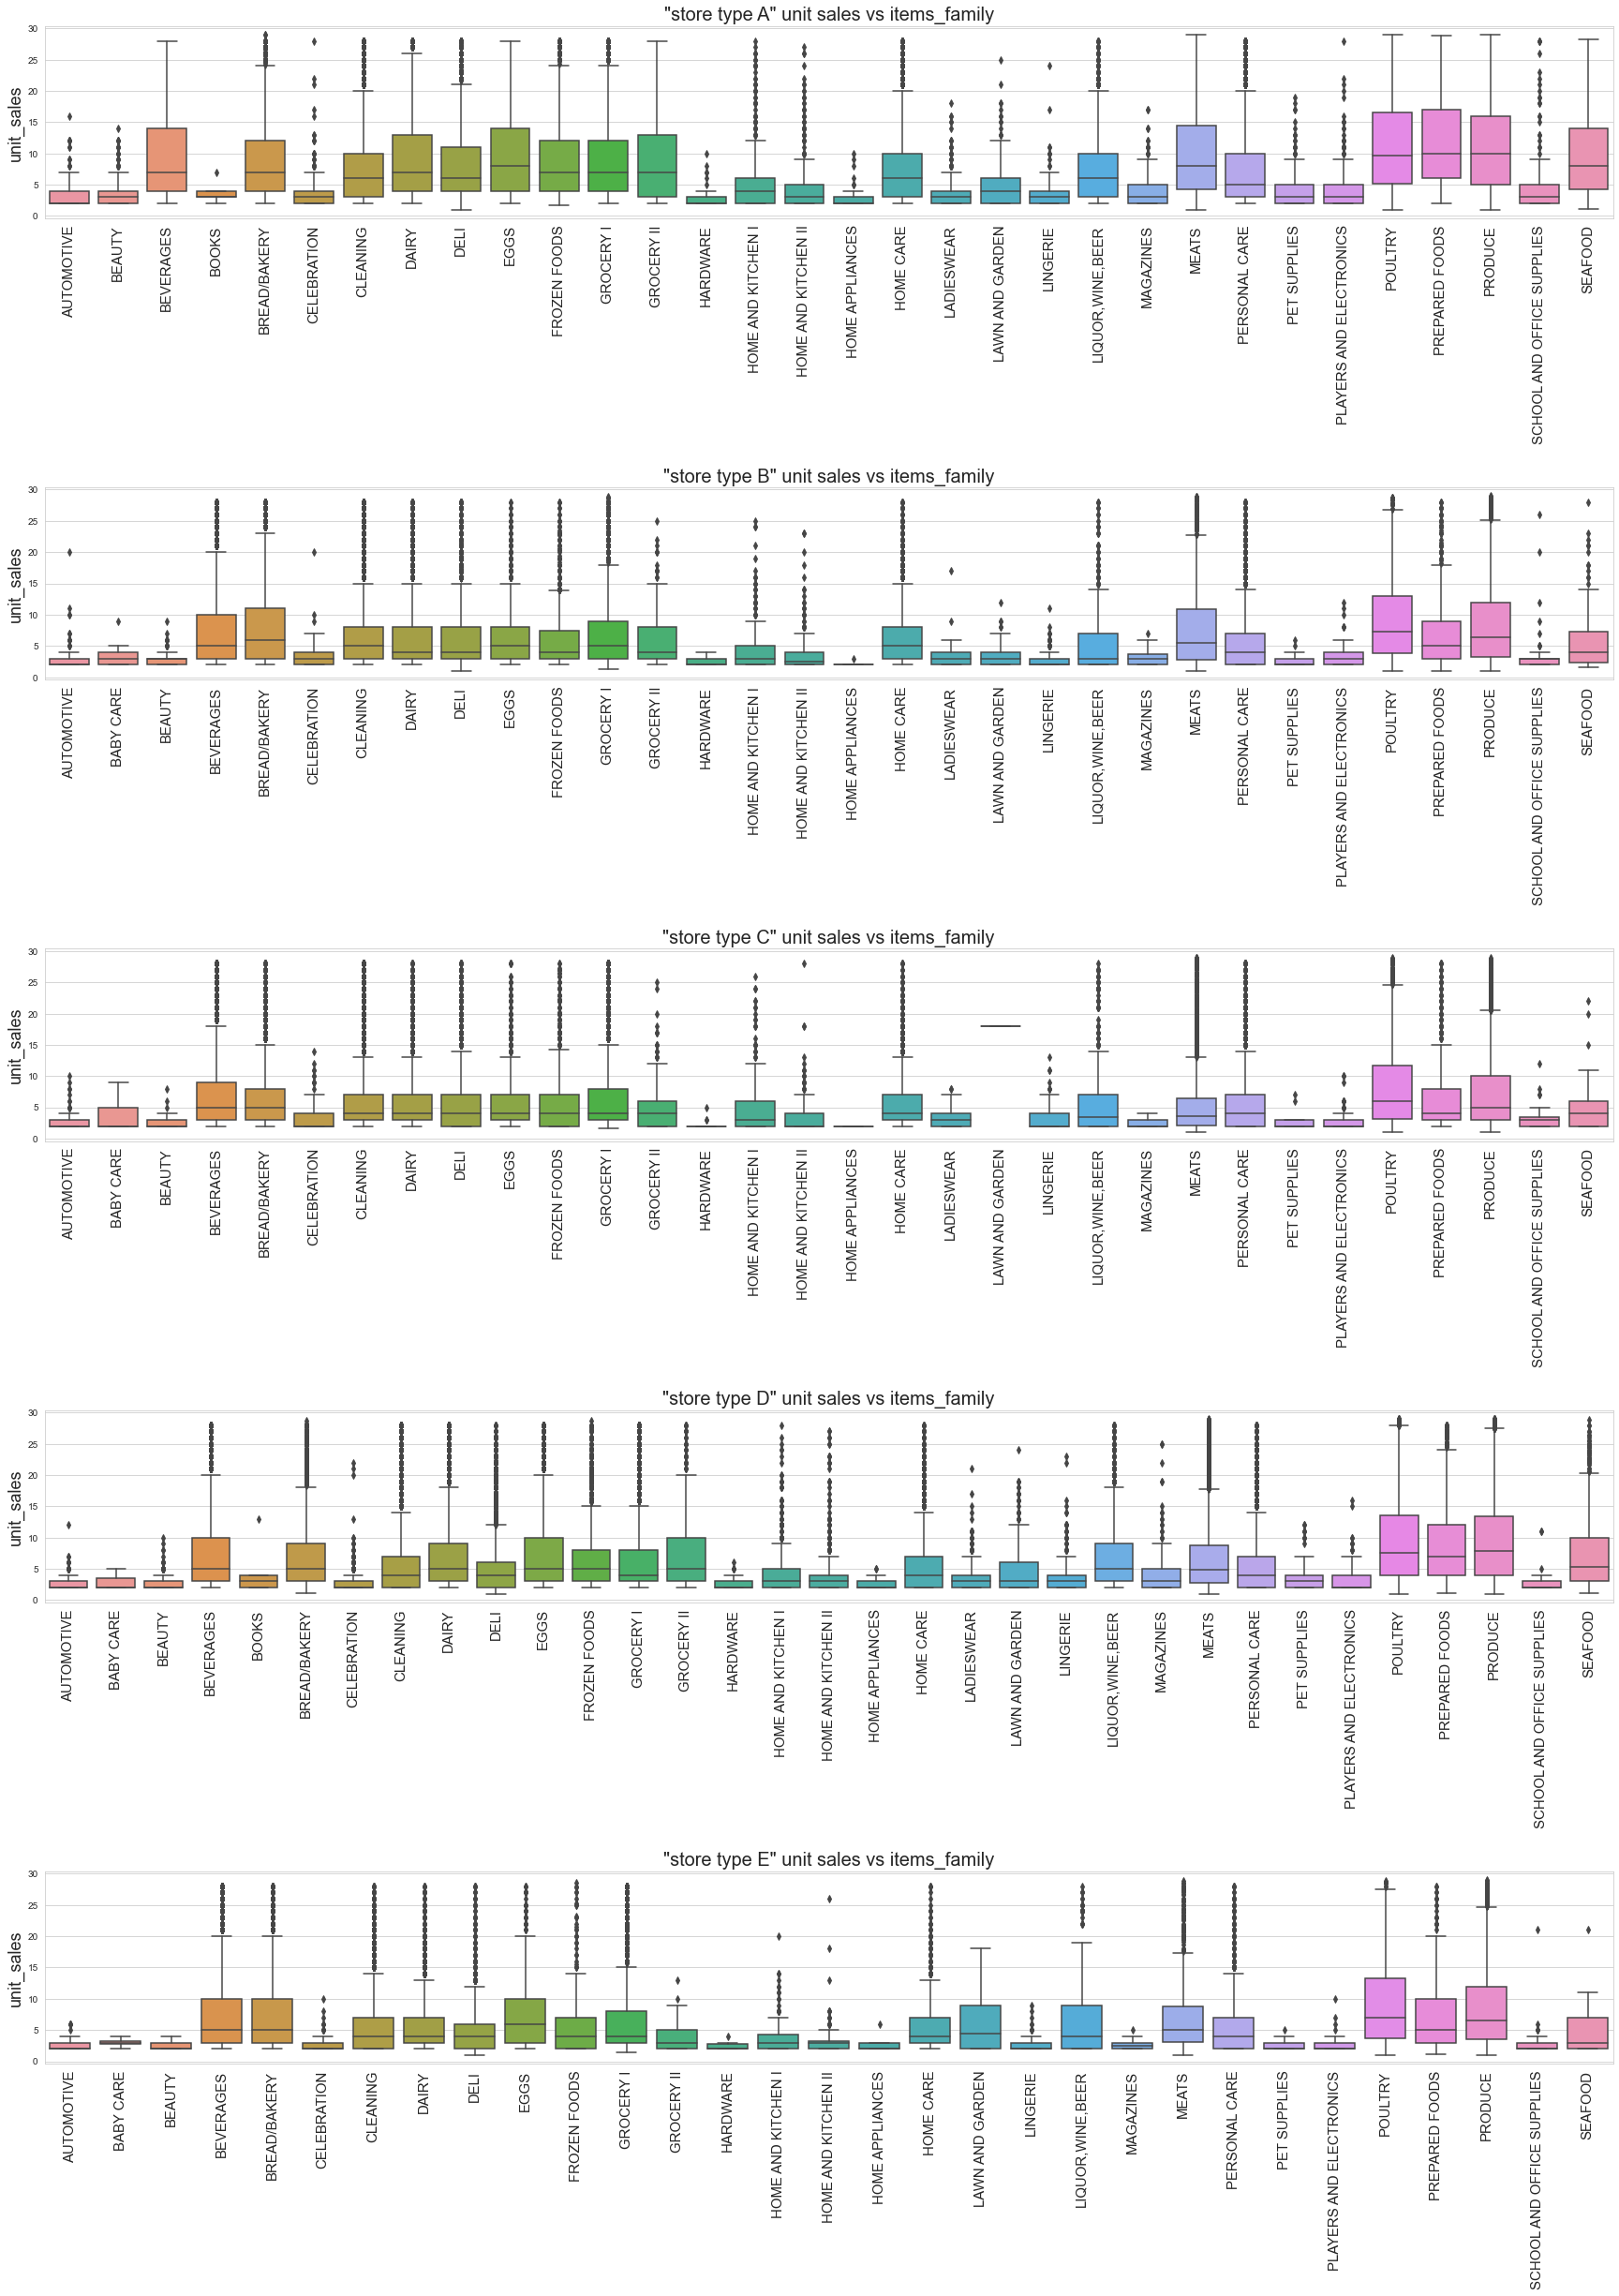

In [53]:
#59

#'unit_sales'(商品の売上)と'items_family'(商品の種類)の関係を'stores_type'(店のタイプ)別に確認してみる。
store_type_list = ['A','B','C','D','E']
fig = plt.figure(figsize=(30,40))
for i,store_type in enumerate(store_type_list):
    ax = fig.add_subplot(5, 1, i + 1)
    store_category_sd = train_df_removed_outliers[train_df_removed_outliers['stores_type']==store_type]
    order_list = sorted(store_category_sd['items_family'].unique())
    sns.boxplot(data=store_category_sd, x='items_family', y='unit_sales', order=order_list, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    ax.set_title('"store type {}" unit sales vs items_family'.format(store_type),fontsize=20)
    ax.tick_params('x', labelsize = 15)
    ax.set_ylabel('unit_sales', fontsize = 18)
    ax.set_xlabel('', fontsize = 0)  
plt.subplots_adjust(hspace=1.4)
plt.show()

'unit_sales'(商品の売上)と'items_family'(商品の種類)の関係を'stores_type'(店のタイプ)別に確認してみる:
- store_type(店の種類)でSEAFOODの売上は多少違いが見られるが後はあまり変わらないように思える

### 3.9 目的変数'unit_sales(商品の売上)'と'trans_transactions(販売取引の数)'との関係を確認する。

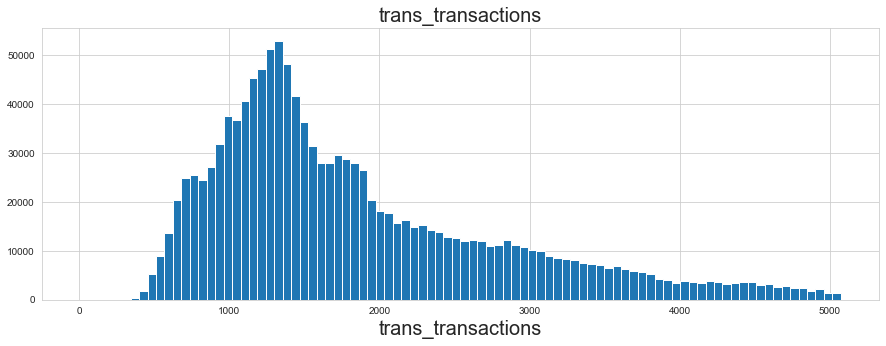

In [54]:
#60

#'trans_transactions(販売取引の数)'のヒストグラムを確認('trans_transactions(販売取引の数)'の外れ値は外す)
trans_transactions_df_removed_outliers = train_merge_df[train_merge_df['trans_transactions'] < train_merge_df['trans_transactions'].quantile(0.99)]['trans_transactions']

plt.figure(figsize=(15,5))
plt.hist(trans_transactions_df_removed_outliers, bins=90)
plt.title('trans_transactions',fontsize=20)
plt.xlabel('trans_transactions',fontsize=20)
plt.show()

'trans_transactions(販売取引の数)'のヒストグラムを確認:
- 1300あたりが一番多いと思われる。

--- Value counts of "trans_group" ---
1        143670
1000     489077
2000     188611
3000      97407
4000+     52290
Name: trans_group, dtype: int64


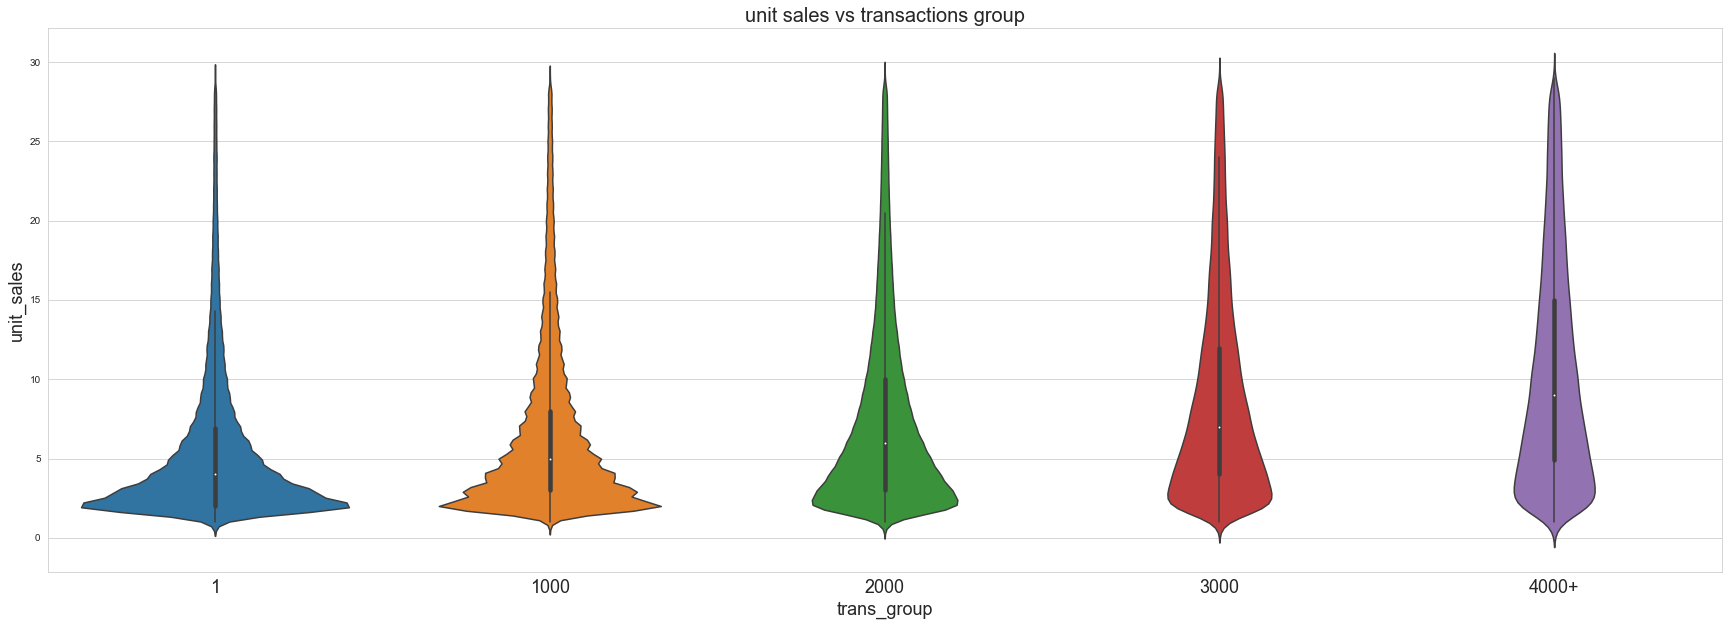

In [55]:
#61

# 'trans_transactions(販売取引の数)'を1000ずつグループに分けて目的変数'unit_sales(商品の売上)'との関係を確認する

lst = [train_df_removed_outliers]
for column in lst:
    column.loc[column['trans_transactions'] < 1000,  'trans_group'] = '1'
    column.loc[(column['trans_transactions'] >= 1000) & (column['trans_transactions'] < 2000), 'trans_group'] = '1000'
    column.loc[(column['trans_transactions'] >= 2000) & (column['trans_transactions'] < 3000), 'trans_group'] = '2000'
    column.loc[(column['trans_transactions'] >= 3000) & (column['trans_transactions'] < 4000), 'trans_group'] = '3000'
    column.loc[column['trans_transactions'] >= 4000, 'trans_group'] = '4000+'

order_list = ['1','1000','2000','3000','4000+']

print('--- Value counts of "trans_group" ---')
print(train_df_removed_outliers['trans_group'].value_counts().reindex(index=order_list))

plt.figure(figsize=(30,10))
sns.violinplot(data=train_df_removed_outliers, x='trans_group', y='unit_sales', order=order_list)
plt.title('unit sales vs transactions group',fontsize=20)
plt.tick_params('x', labelsize = 18)
plt.xlabel('trans_group',fontsize=18)
plt.ylabel('unit_sales',fontsize=18)
plt.show()

'trans_transactions(販売取引の数)'を1000ずつグループに分けて目的変数'unit_sales(商品の売上)'との関係を確認する:
- やはり販売取引の数が多くなっていくにつれて商品の売上は上がっている。
- 商品の売上と販売取引の数を店舗ごとに分けて比べてみる。

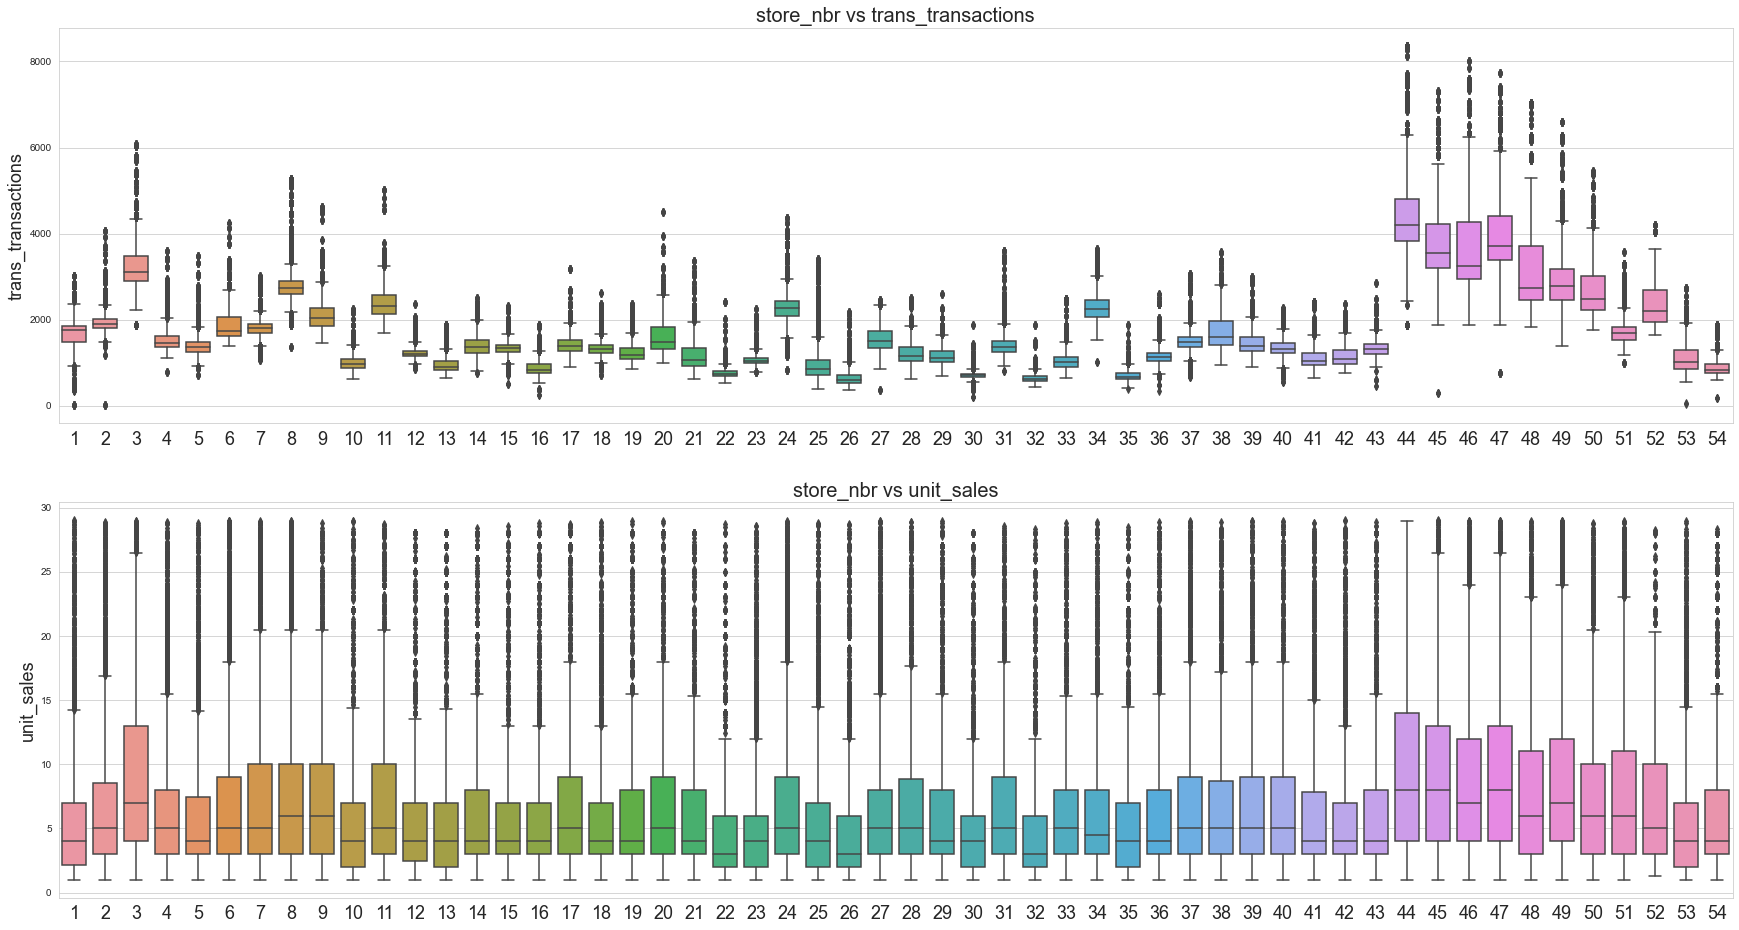

In [56]:
#62

#目的変数'unit_sales(商品の売上)'と'trans_transactions'との関係を店舗ごとに分けて確認する。
fig = plt.figure(figsize=(30,16))
columns_list = ['trans_transactions', 'unit_sales']
for i,column in enumerate(columns_list):
 order_list = sorted(train_df_removed_outliers['store_nbr'].unique())
 ax = fig.add_subplot(2, 1, i + 1)
 sns.boxplot(data=train_df_removed_outliers, x='store_nbr', y=column, ax=ax, order=order_list)
 ax.set_title('store_nbr vs {}'.format(column),fontsize=20)
 ax.tick_params('x', labelsize = 18)
 ax.set_ylabel(column, fontsize = 18)
 ax.set_xlabel('', fontsize = 0)
plt.show()

目的変数'unit_sales(商品の売上)'と'trans_transactions'との関係を店舗ごとに分けて確認する。:
- ２つのグラフを比べると販売取引の数が多い店舗は商品の売上も高いことが分かる。

### 3.10 'unit_sales'と１ヶ月前の'trans_transactions(販売取引数)'の関係を確認
- トレインセットは2013/1/1 ~ 2017/8/15 、テストセットは2017/8/6 ~ 2017/8/31でテストセットの日付の販売取引数は分からない、１ヶ月前の販売取引数と売上に相関があるか確認して相関があったら機械学習モデルで予測するためのデータに１ヶ月前の販売取引数を特徴量にを加える

In [57]:
#63

#１ヶ月前の'trans_transactions(販売取引の数)'を付け加えたデータフレームを作成
from datetime import date,timedelta
past_transactions_df = transactions_df.drop('trans_transactions', axis=1)
transactions_one_month_ago_df = transactions_df.copy()
transactions_one_month_ago_df['date'] = transactions_one_month_ago_df['date'] + timedelta(days=28)
transactions_one_month_ago_df = transactions_one_month_ago_df.rename(columns={'trans_transactions': 'trans_transactions_one_month_ago'})


In [61]:
#64

#作成したデータフレームとトレインデータを結合する
train_df_removed_outliers = train_df_removed_outliers.merge(
    transactions_one_month_ago_df, on=["date","store_nbr"], how='inner')

--- Value counts of "trans_month_ago_group" ---
1        144339
1000     475948
2000     183983
3000      95275
4000+     50566
Name: trans_month_ago_group, dtype: int64


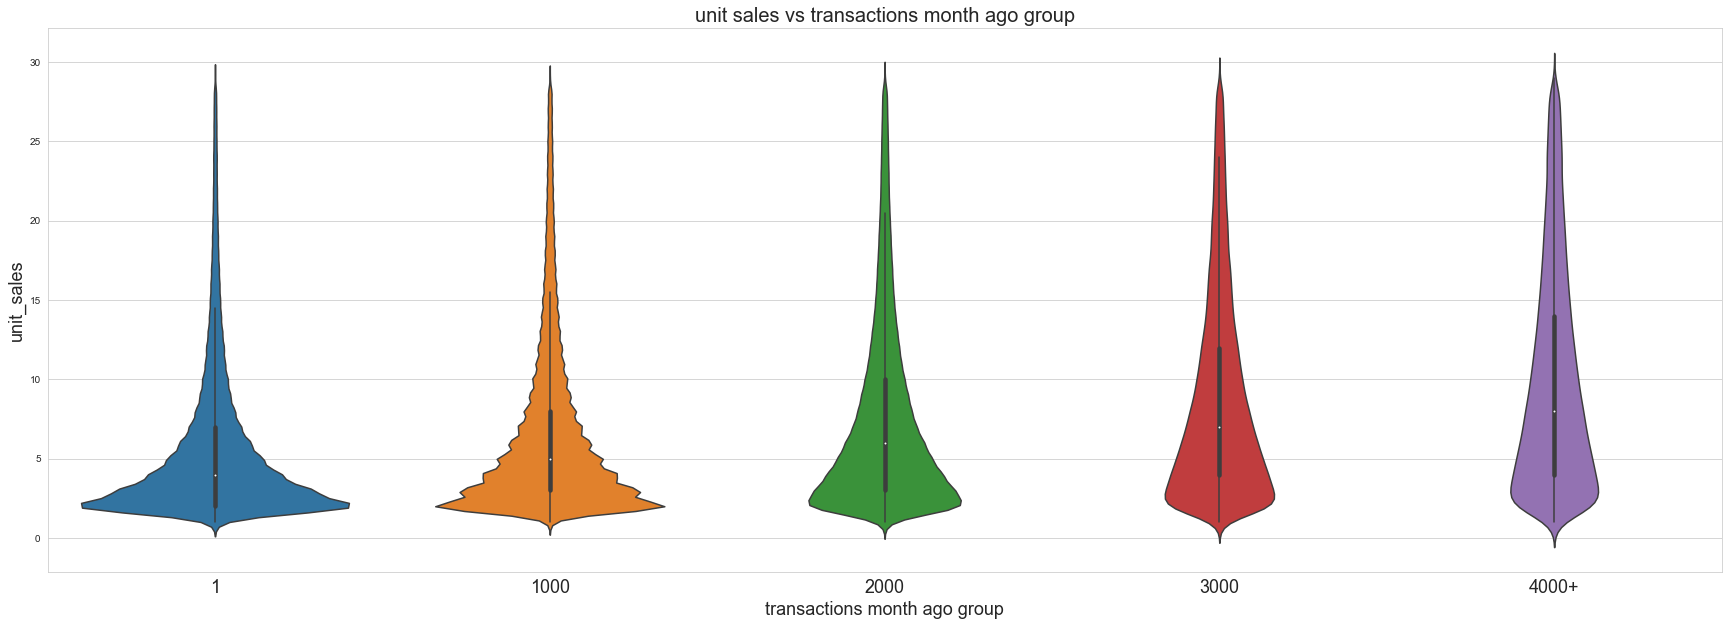

In [62]:
#65

#１ヶ月前の'trans_transactions(販売取引の数)'をグループで分けて目的変数'unit_sales(商品の売上)'との関係を確認する。

lst = [train_df_removed_outliers]
for column in lst:
    column.loc[column['trans_transactions_one_month_ago'] < 1000,  'trans_month_ago_group'] = '1'
    column.loc[(column['trans_transactions_one_month_ago'] >= 1000) & (column['trans_transactions_one_month_ago'] < 2000), 'trans_month_ago_group'] = '1000'
    column.loc[(column['trans_transactions_one_month_ago'] >= 2000) & (column['trans_transactions_one_month_ago'] < 3000), 'trans_month_ago_group'] = '2000'
    column.loc[(column['trans_transactions_one_month_ago'] >= 3000) & (column['trans_transactions_one_month_ago'] < 4000), 'trans_month_ago_group'] = '3000'
    column.loc[column['trans_transactions_one_month_ago'] >= 4000, 'trans_month_ago_group'] = '4000+'

order_list = ['1','1000','2000','3000','4000+']

print('--- Value counts of "trans_month_ago_group" ---')
print(train_df_removed_outliers['trans_month_ago_group'].value_counts().reindex(index=order_list))

plt.figure(figsize=(30,10))
sns.violinplot(data=train_df_removed_outliers, x='trans_month_ago_group', y='unit_sales', order=order_list)
plt.title('unit sales vs transactions month ago group',fontsize=20)
plt.tick_params('x', labelsize = 18)
plt.xlabel('transactions month ago group', fontsize = 18)
plt.ylabel('unit_sales',fontsize=18)
plt.show()

１ヶ月前の'trans_transactions(販売取引の数)'をグループで分けて目的変数'unit_sales'との関係を確認する。:
- １ヶ月前の販売取引の数も売上と相関がある。
- 機械学習モデルで予測するためのデータに１ヶ月前の販売取引数を加える

### 3.11 目的変数'unit_sales'と'祝日に関する特徴量('holidays_type', 'holidays_locale', 'holidays_locale_name')との関係を確認する。

--- Value counts of "holidays_type" ---
holidays_type
Additional      23657
Bridge           1850
Event           35728
Holiday         88040
Transfer         5518
Work Day         1819
not_holiday    780393
Name: holidays_type, dtype: int64


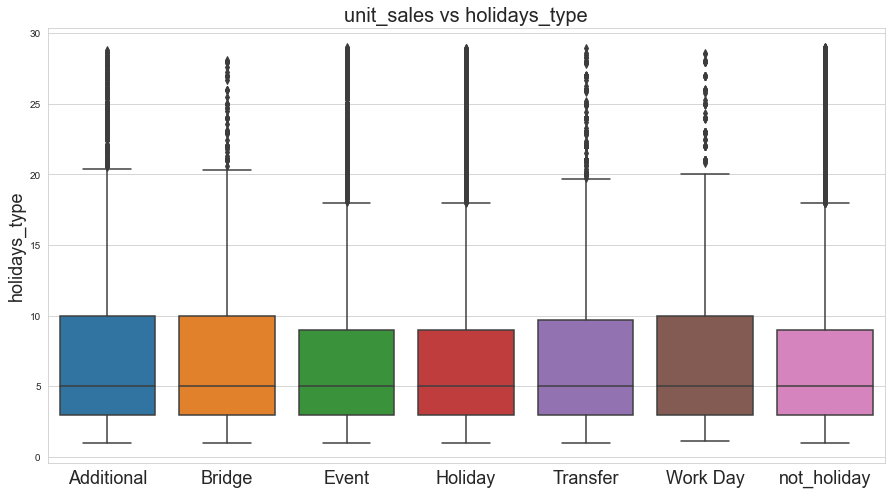

--- Value counts of "holidays_locale" ---
holidays_locale
Local           64566
National        81426
Regional        10620
not_holiday    780393
Name: holidays_locale, dtype: int64


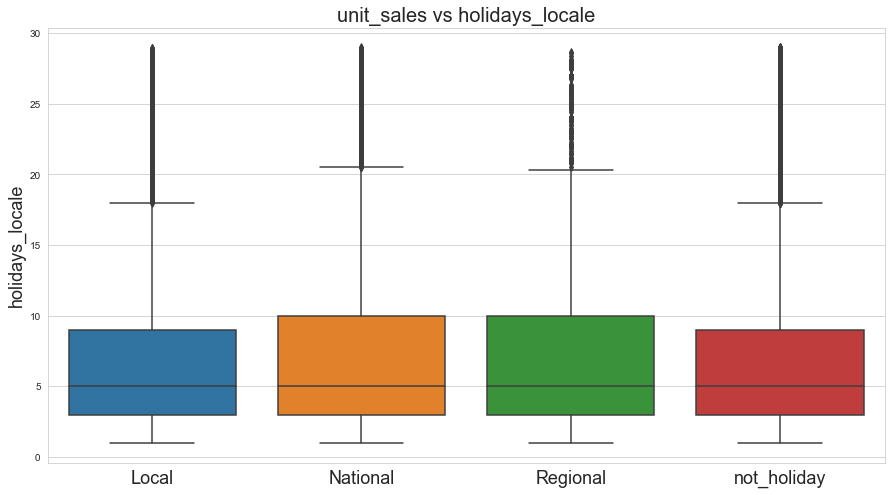

--- Value counts of "holidays_locale_name" ---
holidays_locale_name
Cotopaxi                            2929
Ambato                              4404
Loja                                2293
Santo Domingo de los Tsachilas      2386
Santo Domingo                       3175
Santa Elena                         2408
Salinas                             2547
Riobamba                            4815
Quito                               5042
Quevedo                             2220
Puyo                                2678
Manta                               2905
Machala                             2897
not_holiday                       780393
Cayambe                             2990
Latacunga                           5106
Imbabura                            2897
Ibarra                              2234
Guayaquil                           5849
Guaranda                            4880
Esmeraldas                          2142
El Carmen                           3175
Ecuador                       

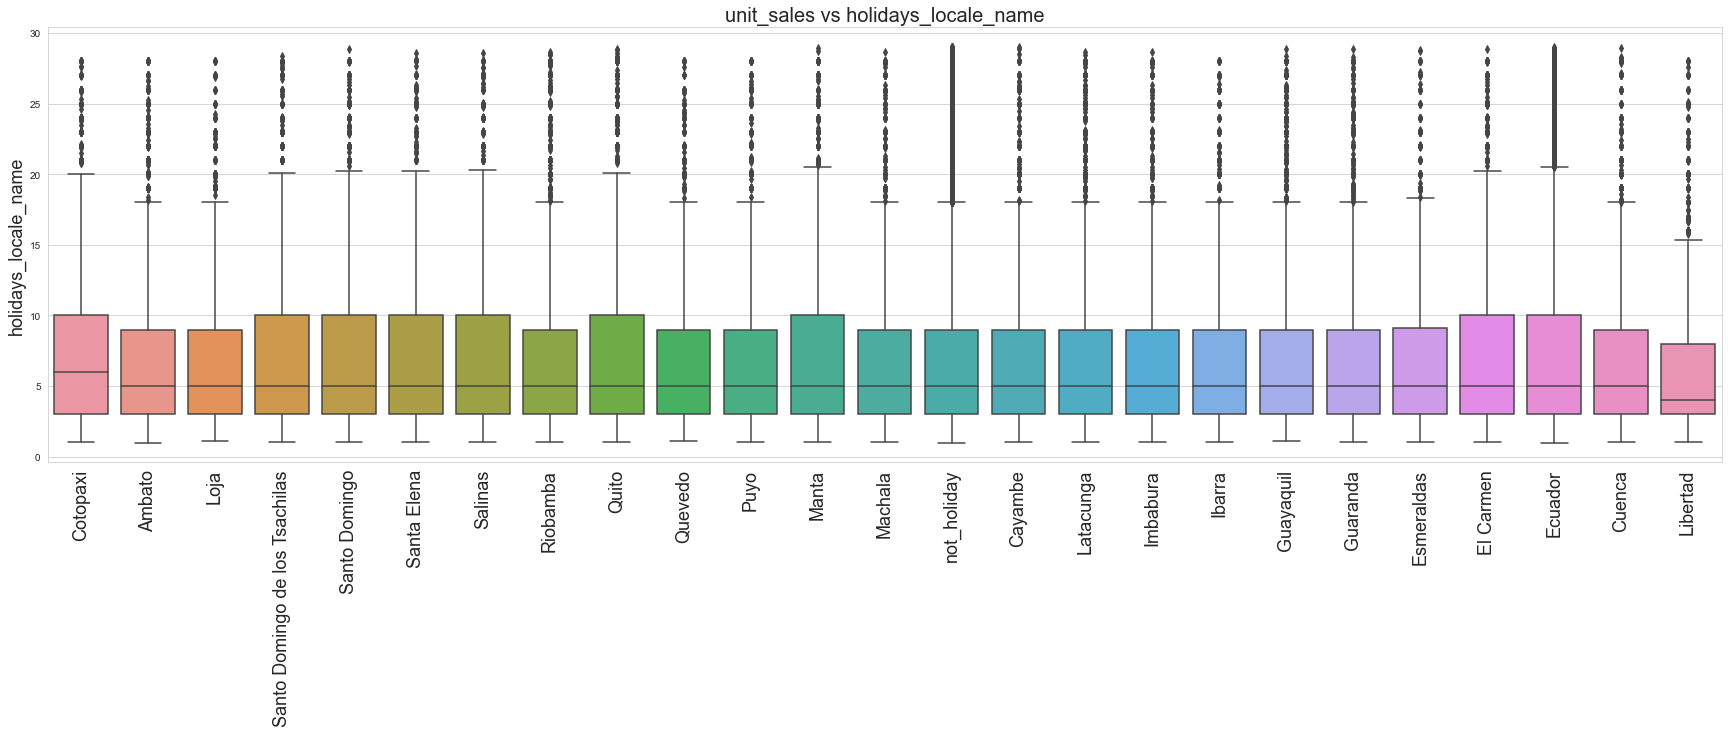

In [58]:
#66

#目的変数'unit_sales'と'祝日に関する特徴量('holidays_type', 'holidays_locale', 'holidays_locale_name')との関係を確認する
#order=order_list

columns_list = ['holidays_type', 'holidays_locale', 'holidays_locale_name']
for column in columns_list:
    order_list = train_df_removed_outliers.groupby(column)['unit_sales'].median().sort_values(ascending=False).index
    
    print(f'--- Value counts of "{column}" ---')
    print(train_df_removed_outliers[column].value_counts().reindex(index=order_list))
    
    if column == 'holidays_type' or column == 'holidays_locale':
       fig = plt.figure(figsize=(15,8))
       ax = fig.add_subplot()
       sns.boxplot(data=train_df_removed_outliers, x=column, y='unit_sales', order=order_list, ax=ax)
    else:
       fig = plt.figure(figsize=(30,8))
       ax = fig.add_subplot()
       sns.boxplot(data=train_df_removed_outliers, x=column, y='unit_sales', order=order_list, ax=ax)
       ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
 
    ax.set_title('unit_sales vs {}'.format(column),fontsize=20)
    ax.tick_params('x', labelsize = 18)
    ax.set_ylabel(column, fontsize = 18)
    ax.set_xlabel('', fontsize = 0)
    plt.show()

目的変数'unit_sales(商品の売上)'と'祝日に関する特徴量('holidays_type', 'holidays_locale', 'holidays_locale_name')との関係を確認する:
- 祝日に関する特徴量はあまり売上に相関がないように思える。
- データを祝日とそれ以外で分けて他の特徴量と掛け合わせて違いがあるか確認する

--- Value counts of "holiday_group" ---
not_holiday    810434
holiday        160621
Name: holiday_group, dtype: int64


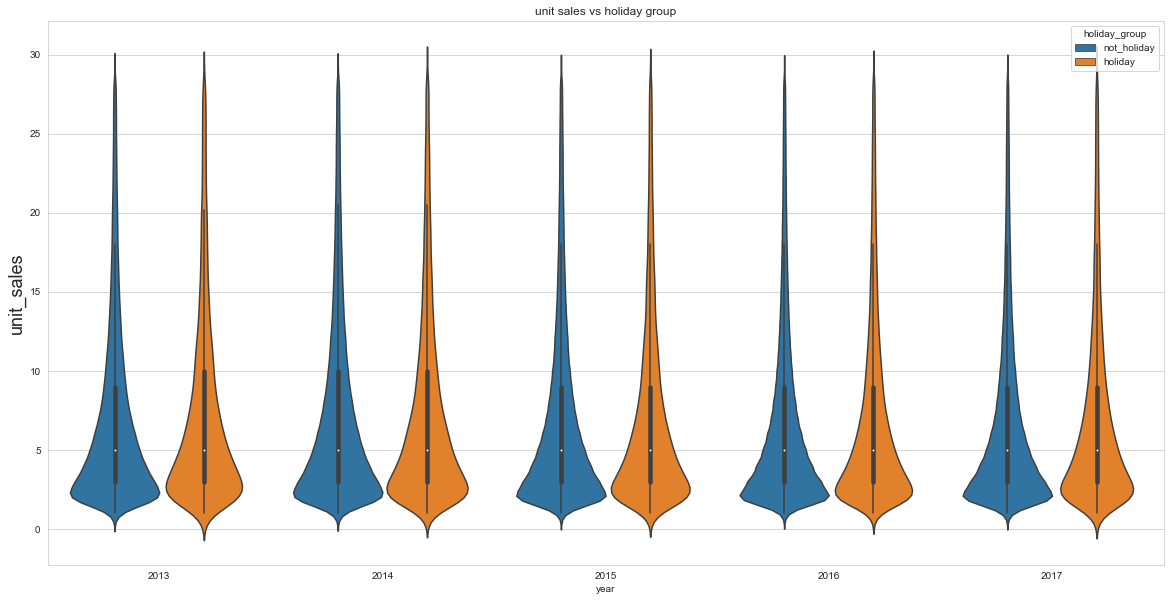

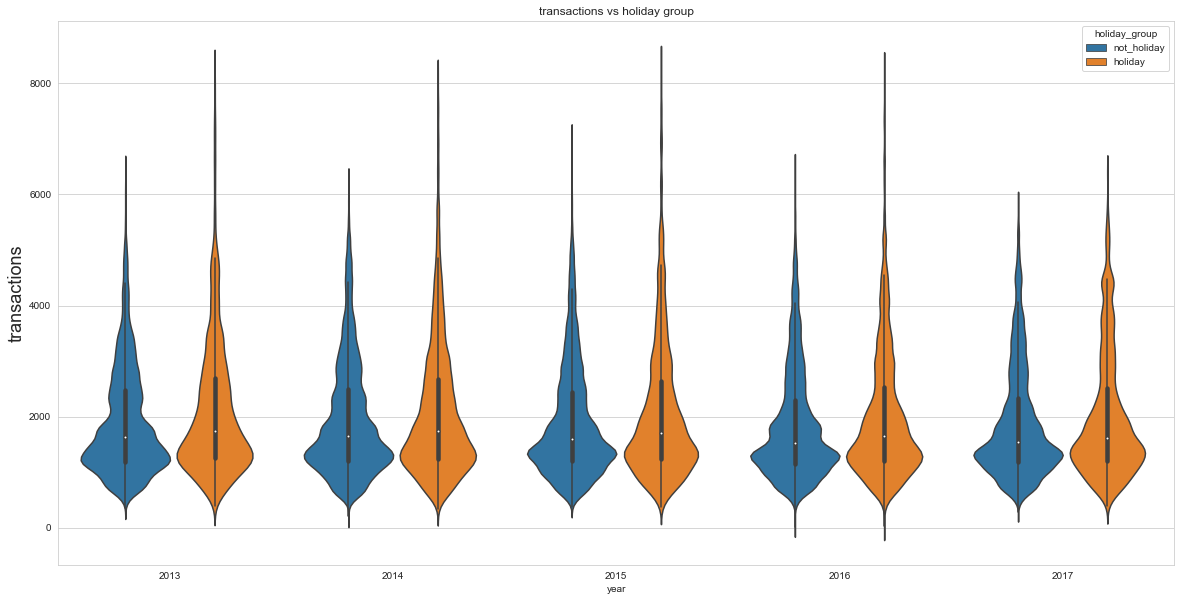

In [54]:
#67

#データを祝日とそれ以外で分けて'year'や'trans_transactions'と掛け合わせて違いがあるか確認する

lst = [train_df_removed_outliers]
for column in lst:
    column.loc[column['holidays_type'] != 'not_holiday',  'holiday_group'] = 'holiday'
    column.loc[column['holidays_type'] == 'not_holiday', 'holiday_group'] = 'not_holiday'

print('--- Value counts of "holiday_group" ---')
print(train_df_removed_outliers['holiday_group'].value_counts())

plt.figure(figsize=(20, 10))
plt.title('unit sales vs holiday group')
sns.violinplot(data=train_df_removed_outliers, x='year', y='unit_sales', hue='holiday_group')
plt.ylabel('unit_sales', fontsize = 18)
plt.show()

plt.figure(figsize=(20, 10))
plt.title('transactions vs holiday group')
sns.violinplot(data=train_df_removed_outliers, x='year', y='trans_transactions', hue='holiday_group')
plt.ylabel('transactions', fontsize = 18)
plt.show()

データを祝日とそれ以外で分けて'year'や'trans_transactions'と掛け合わせて違いがあるか確認する:
- 祝日に関する特徴量はあまり売上に相関がないように思える。

### 3.12 連続変数('trans_transactions(販売取引数)', 'oil_dcoilwtico(石油価格)')と'unit_sales'の相関係数図を確認する

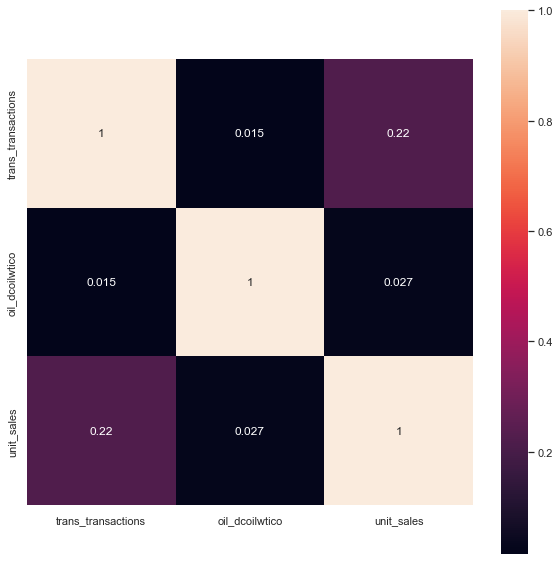

In [60]:
#68

#連続変数('year','month','day','stores_cluster', 'trans_transactions', 'oil_dcoilwtico')と'unit_sales'の相関係数図を確認する
continuous_variable_columns = ['trans_transactions', 'oil_dcoilwtico','unit_sales']

corr_matrix = train_df_removed_outliers[continuous_variable_columns].corr()
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(corr_matrix,
            square=True,
            annot=True,
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)
plt.show()

連続変数('trans_transactions', 'oil_dcoilwtico')と目的変数'unit_sales'の相関係数図を確認する:
- 連続変数の中では'transactions'がunit_sales'と相関が高い

# 4 特徴量エンジニアリング
- トレインデータを'2013-06-01'~'2017-07-31'、
検証データを'2013-08-01'~'2017-08-14'、
テストデータを'2017-08-15'~'2017-08-31'を使う。
- 'unit_sales'を対数変換する
- 過去の'unit_sales(売上)','onpromotion(プロモーションされてたかどうか)','trans_transactions(販売取引数)'を特徴量として加える

### 4.1 必要なデータだけ取り出し'unit_sales(売上)'を対数変換する

In [39]:
#69

future_engineering_df = concat_merge_df.copy()

In [27]:
#70

#必要なデータだけ取り出す
future_engineering_df = future_engineering_df[(future_engineering_df['date']>='2017-04-24')&(future_engineering_df['date']<='2017-08-31')]

In [28]:
#71

#'unit_sales'を対数変換する

future_engineering_df["unit_sales"] = future_engineering_df["unit_sales"].apply(lambda u: np.log1p( float(u)) if float(u) > 0 else 0)

### 4.2  過去の'unit_sales(売上)','onpromotion(プロモーションされてたかどうか)'を特徴量に加える。

In [29]:
#72

#16日前~43日前の'unit_sales','onpromotion'を特徴量に加える

#'onpromotion'が'yes'だったら1、'no'または'unknown'だったら0にする
def str_to_num(x):
    if x == 'yes':
        return 1
    else:
        return 0
future_engineering_df['onpromotion'] = future_engineering_df['onpromotion'].apply(str_to_num)

#過去の'unit_sales','onpromotion'の土台のデータフレームを作成
date_and_sales_df = future_engineering_df[['date','store_nbr','item_nbr','unit_sales','onpromotion']]
date_and_sales_df = date_and_sales_df[date_and_sales_df['date']<='2017-08-15']
date_and_sales_df = date_and_sales_df.rename(columns={'unit_sales': 'past_unit_sales','onpromotion':'past_onpromotion'})
date_and_sales_df = date_and_sales_df.groupby(['date','store_nbr','item_nbr'], as_index=False).mean()

#メインのデータフレームを
future_engineering_df = future_engineering_df[(future_engineering_df['date']>='2017-06-01')&(future_engineering_df['date']<='2017-08-31')]

#カラムのリストを作成して後で並び替える
order_columns_1 = future_engineering_df.columns.values.tolist()
order_columns_2 = []
order_columns_3 = []

from datetime import date,timedelta

#16日前~43日前の'unit_sales','onpromotion'を特徴量に加える
past_days = 44
for d in range(16, past_days):
 
    #N日前のデータフレームを作成
    past_date_and_sales_df = pd.DataFrame()
    past_date_and_sales_df = date_and_sales_df.copy()
    past_date_and_sales_df['date'] = past_date_and_sales_df['date'] + timedelta(days=d)

    #過去のデータフレームとメインデータフレームを結合する
    future_engineering_df = future_engineering_df.merge(
        past_date_and_sales_df, on=["date","store_nbr","item_nbr"], how='left')
    future_engineering_df = future_engineering_df.rename(columns={'past_unit_sales': '{}_days_ago_sales'.format(d),'past_onpromotion': '{}_days_ago_onpromotion'.format(d)})
    
    #カラムのリストを作成
    order_columns_2.append('{}_days_ago_sales'.format(d))
    order_columns_3.append('{}_days_ago_onpromotion'.format(d))
    
    #'onpromotion'の欠損値を0で埋める
    future_engineering_df['{}_days_ago_onpromotion'.format(d)].fillna(0)
    #'unit_sales'の欠損値は、店舗でグループ分けした各商品の'unit_sales'の平均で埋める
    future_engineering_df['{}_days_ago_sales'.format(d)] = future_engineering_df[['date','store_nbr','{}_days_ago_sales'.format(d)]].groupby(['date','store_nbr']).transform(lambda x: x.fillna(x.mean()))
    #もしまだ'unit_sales'の欠損値があったら日にちが近い'unit_sales'で埋める
    future_engineering_df = future_engineering_df.fillna(method='bfill')
    #もしまだ'unit_sales'の欠損値があったら'unit_sales'の平均で埋める
    future_engineering_df = future_engineering_df.fillna(future_engineering_df['{}_days_ago_sales'.format(d)].mean())

#カラムを並び替える
future_engineering_df = future_engineering_df[order_columns_1 + order_columns_2 + order_columns_3]

In [8]:
#73

#新しく加えた特徴量(15日前~43日前)の一部を確認
future_engineering_df[['date','store_nbr','item_nbr','34_days_ago_sales','35_days_ago_sales','36_days_ago_sales','34_days_ago_onpromotion','35_days_ago_onpromotion','36_days_ago_onpromotion']].head()

,date,store_nbr,item_nbr,34_days_ago_sales,35_days_ago_sales,36_days_ago_sales,34_days_ago_onpromotion,35_days_ago_onpromotion,36_days_ago_onpromotion
0,2017-06-01,1,99197,1.625274,1.520142,1.693798,0.0,0.0,0.0
1,2017-06-01,1,103520,1.098612,1.098612,1.693798,0.0,0.0,0.0
2,2017-06-01,1,105574,2.079442,2.397895,1.791759,1.0,0.0,0.0
3,2017-06-01,1,105575,2.484907,1.609438,2.397895,0.0,0.0,0.0
4,2017-06-01,1,105577,1.625274,1.386294,0.693147,0.0,0.0,0.0


In [9]:
#74

#3週間前、4週間前、5週間前、6週間前、の'unit_sales'の平均を特徴量に加える
columns_list = []
onpromotion_columns_list = []

for d in range(21, 43, 7):
    columns_list.append('{}_days_ago_sales'.format(d))
    onpromotion_columns_list.append('{}_days_ago_onpromotion'.format(d))
future_engineering_df['mean_3_4_5_6_weeks_ago'] = future_engineering_df[columns_list].mean(axis='columns')
future_engineering_df['onpromotion_mean_3_4_5_6_weeks_ago'] = future_engineering_df[onpromotion_columns_list].mean(axis='columns')

In [10]:
#75

#新しく加えた特徴量(週間前、4週間前、5週間前、6週間前、の'unit_sales'の平均)を確認
future_engineering_df[['date','store_nbr','item_nbr','mean_3_4_5_6_weeks_ago','onpromotion_mean_3_4_5_6_weeks_ago']].head()

,date,store_nbr,item_nbr,mean_3_4_5_6_weeks_ago,onpromotion_mean_3_4_5_6_weeks_ago
0,2017-06-01,1,99197,1.354532,0.0
1,2017-06-01,1,103520,1.529096,0.0
2,2017-06-01,1,105574,1.853917,0.0
3,2017-06-01,1,105575,2.005451,0.0
4,2017-06-01,1,105577,1.371944,0.0


In [12]:
#76

#15日前~16日前、15日前~17日前、15日前~18日前、15日前~19日前 ...　15日前~31日前の'unit_sales'の平均を特徴量に加える
for d in range(16, 32):
    future_engineering_df['mean_16_{}'.format(d)] = future_engineering_df.loc[:, '16_days_ago_sales':'{}_days_ago_sales'.format(d)].mean(axis='columns')
    future_engineering_df['onpromotion_mean_16_{}'.format(d)] = future_engineering_df.loc[:, '16_days_ago_onpromotion':'{}_days_ago_onpromotion'.format(d)].mean(axis='columns')

In [13]:
#77

#新しく加えた特徴量(15日前~16日前、15日前~17日前、15日前~18日前、15日前~19日前 ...　15日前~31日前の'unit_sales'の平均)の一部を確認
future_engineering_df[['date','store_nbr','item_nbr','mean_16_17','mean_16_18','mean_16_19','onpromotion_mean_16_17','onpromotion_mean_16_18','onpromotion_mean_16_19']].head()

,date,store_nbr,item_nbr,mean_16_17,mean_16_18,mean_16_19,onpromotion_mean_16_17,onpromotion_mean_16_18,onpromotion_mean_16_19
0,2017-06-01,1,99197,1.098612,1.144227,1.275376,0.0,0.0,0.0
1,2017-06-01,1,103520,1.151293,1.179347,1.159163,0.0,0.0,0.0
2,2017-06-01,1,105574,2.297560,1.897911,1.871373,0.0,0.0,0.0
3,2017-06-01,1,105575,2.197225,1.926915,2.153489,0.0,0.0,0.0
4,2017-06-01,1,105577,1.039721,1.104966,1.103378,0.0,0.0,0.0


In [22]:
#78

# 2週間前~3週間前、3週間前~4週間前、4週間前~5週間前の'unit_sales'の平均を特徴量に加える

for d in range(16, 37, 7):
    future_engineering_df['mean_one_week_{}_{}'.format(d, d+6)] = future_engineering_df.loc[:, '{}_days_ago_sales'.format(d):'{}_days_ago_sales'.format(d+6)].mean(axis='columns')
    future_engineering_df['onpromotion_mean_one_week_{}_{}'.format(d, d+6)] = future_engineering_df.loc[:, '{}_days_ago_onpromotion'.format(d):'{}_days_ago_onpromotion'.format(d+6)].mean(axis='columns')

In [23]:
#79

#新しく加えた特徴量(2週間前~3週間前、3週間前~4週間前、4週間前~5週間前のの'unit_sales'平均)を確認
future_engineering_df[['date','store_nbr','item_nbr','mean_one_week_16_22','mean_one_week_23_29','onpromotion_mean_one_week_16_22','onpromotion_mean_one_week_23_29']].head()

,date,store_nbr,item_nbr,mean_one_week_16_22,mean_one_week_23_29,onpromotion_mean_one_week_16_22,onpromotion_mean_one_week_23_29
0,2017-06-01,1,99197,1.025850,1.588171,0.0,0.0
1,2017-06-01,1,103520,1.437949,1.245216,0.0,0.0
2,2017-06-01,1,105574,1.997467,2.106495,0.0,0.0
3,2017-06-01,1,105575,2.225171,2.114651,0.0,0.0
4,2017-06-01,1,105577,1.142433,1.204409,0.0,0.0


In [24]:
#80

#4週間前の'unit_sales'の合計、平均、分散、、標準偏差、最高額、最低額を特徴量に加える。
from datetime import date,timedelta

sales_cal_df = date_and_sales_df.groupby(["date","store_nbr"])['past_unit_sales'].agg([np.sum, np.mean, np.max, np.min, np.std, np.var])

sales_cal_df.reset_index(inplace= True)

sales_cal_df['date'] = sales_cal_df['date'] + timedelta(days=28)

future_engineering_df = future_engineering_df.merge(
    sales_cal_df, on=["date","store_nbr"], how='inner')

In [25]:
#81

#新しく加えた特徴量(4週間前の'unit_sales'の合計、平均、分散、、標準偏差、最高額、最低額)を確認
future_engineering_df[['date','store_nbr','item_nbr','sum', 'mean', 'amax', 'amin', 'std', 'var']].head()

,date,store_nbr,item_nbr,sum,mean,amax,amin,std,var
0,2017-06-01,1,99197,3141.638455,1.494595,4.829097,0.10075,0.738135,0.544843
1,2017-06-01,1,103520,3141.638455,1.494595,4.829097,0.10075,0.738135,0.544843
2,2017-06-01,1,105574,3141.638455,1.494595,4.829097,0.10075,0.738135,0.544843
3,2017-06-01,1,105575,3141.638455,1.494595,4.829097,0.10075,0.738135,0.544843
4,2017-06-01,1,105577,3141.638455,1.494595,4.829097,0.10075,0.738135,0.544843


### 4.3 4週間前のその店舗の'trans_transactions(販売取引数)'を特徴量に加える。(予想がしたい日の'trans_transactions'はわからない)

In [27]:
#82

#データに１ヶ月前の'trans_transactions(販売取引数)'を加える

future_engineering_df = future_engineering_df.merge(
    transactions_one_month_ago_df , on=["date","store_nbr"], how='inner')

In [28]:
#83
 
#新しく加えた特徴量(１ヶ月前の'trans_transactions(販売取引数))を確認
future_engineering_df[['date','store_nbr','item_nbr','trans_transactions_one_month_ago']].head()

,date,store_nbr,item_nbr,trans_transactions_one_month_ago
0,2017-06-01,1,99197,1729
1,2017-06-01,1,103520,1729
2,2017-06-01,1,105574,1729
3,2017-06-01,1,105575,1729
4,2017-06-01,1,105577,1729


### 4.4 その他必要な前処理をする

In [29]:
#84

#'items_perishable'を評価指標で使うために指定されている重みに変える
future_engineering_df['items_perishable'] = future_engineering_df['items_perishable'].map({0:1.0, 1:1.25})

In [30]:
#85

# カテゴリ変数をダミー変数に変える
future_engineering_df = pd.get_dummies(future_engineering_df)

In [31]:
#86

#トレインデータを'2013-06-01'~'2017-07-31'、
#検証データを'2013-08-01'~'2017-08-14'、
#テストデータを'2017-08-15'~'2017-08-31'に分ける

train_data_for_model_df = future_engineering_df[(future_engineering_df['date']<'2017-08-01')&(future_engineering_df['date']>='2017-06-01')]
val_data_for_model_df = future_engineering_df[(future_engineering_df['date']<'2017-08-15')&(future_engineering_df['date']>='2017-08-01')]
test_data_for_model_df = future_engineering_df[(future_engineering_df['date']<='2017-08-31')&(future_engineering_df['date']>='2017-08-16')]

remove_columns = ['date','trans_transactions', 'unit_sales']

X_train, y_train = train_data_for_model_df.drop(remove_columns,axis=1), train_data_for_model_df['unit_sales']
X_val, y_val = val_data_for_model_df.drop(remove_columns,axis=1), val_data_for_model_df['unit_sales']
X_test, y_test = test_data_for_model_df.drop(remove_columns,axis=1), test_data_for_model_df['unit_sales']

# 5, 機械学習 <a id="5"></a>
評価指標はNormalized Weighted Root Mean Squared Logarithmic Error(NWRMSLE)を使う
$$ NWRMSLE = \sqrt{ \frac{\sum_{i=1}^{n} wi \left( \log(\hat{y}_{i} + 1) - \log(y_{i} +1)  \right)^2  }{\sum_{i=1}^{n} w_{i}}} $$
- wにはitems.csvの'perishable'(その商品が腐りやすいかどうか)を使う。腐りやすい商品は1.25、腐りにくい商品は1で計算される。

### 5.1 LightGMBで学習する

In [32]:
#87
#モデルの構築
import lightgbm as lgb 
import re

X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_val = X_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train) 

params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression', 
        'metric': {'rmse'}, 
        'learning_rate': 0.1,
        'num_leaves': 23,
        'min_data_in_leaf': 1,
        'num_iteration': 5000, 
        'verbose': 0
}

model = lgb.train(params,
                  train_set=lgb_train, 
                  valid_sets=lgb_eval, 
                  early_stopping_rounds=100
                  )

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.648272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 0.813602
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.771822
[3]	valid_0's rmse: 0.736102
[4]	valid_0's rmse: 0.705519
[5]	valid_0's rmse: 0.679605
[6]	valid_0's rmse: 0.657953
[7]	valid_0's rmse: 0.639467
[8]	valid_0's rmse: 0.623806
[9]	valid_0's rmse: 0.610736
[10]	valid_0's rmse: 0.599732
[11]	valid_0's rmse: 0.590484
[12]	valid_0's rmse: 0.582803
[13]	valid_0's rmse: 0.576317
[14]	valid_0's rmse: 0.570956
[15]	valid_0's rmse: 0.566443
[16]	valid_0's rmse: 0.562642
[17]	valid_0's rmse: 0.55901
[18]	valid_0's rmse: 0.556273
[19]	valid_0's rmse: 0.553813
[20]	valid_0's rmse: 0.551784
[21]	valid_0's rmse: 0.549952
[22]	valid_0's rmse: 0.54843
[23]	valid_0's rmse: 0.547024
[24]	valid_0's rmse: 0.545773


### 5.2 特徴量の重要度を確認

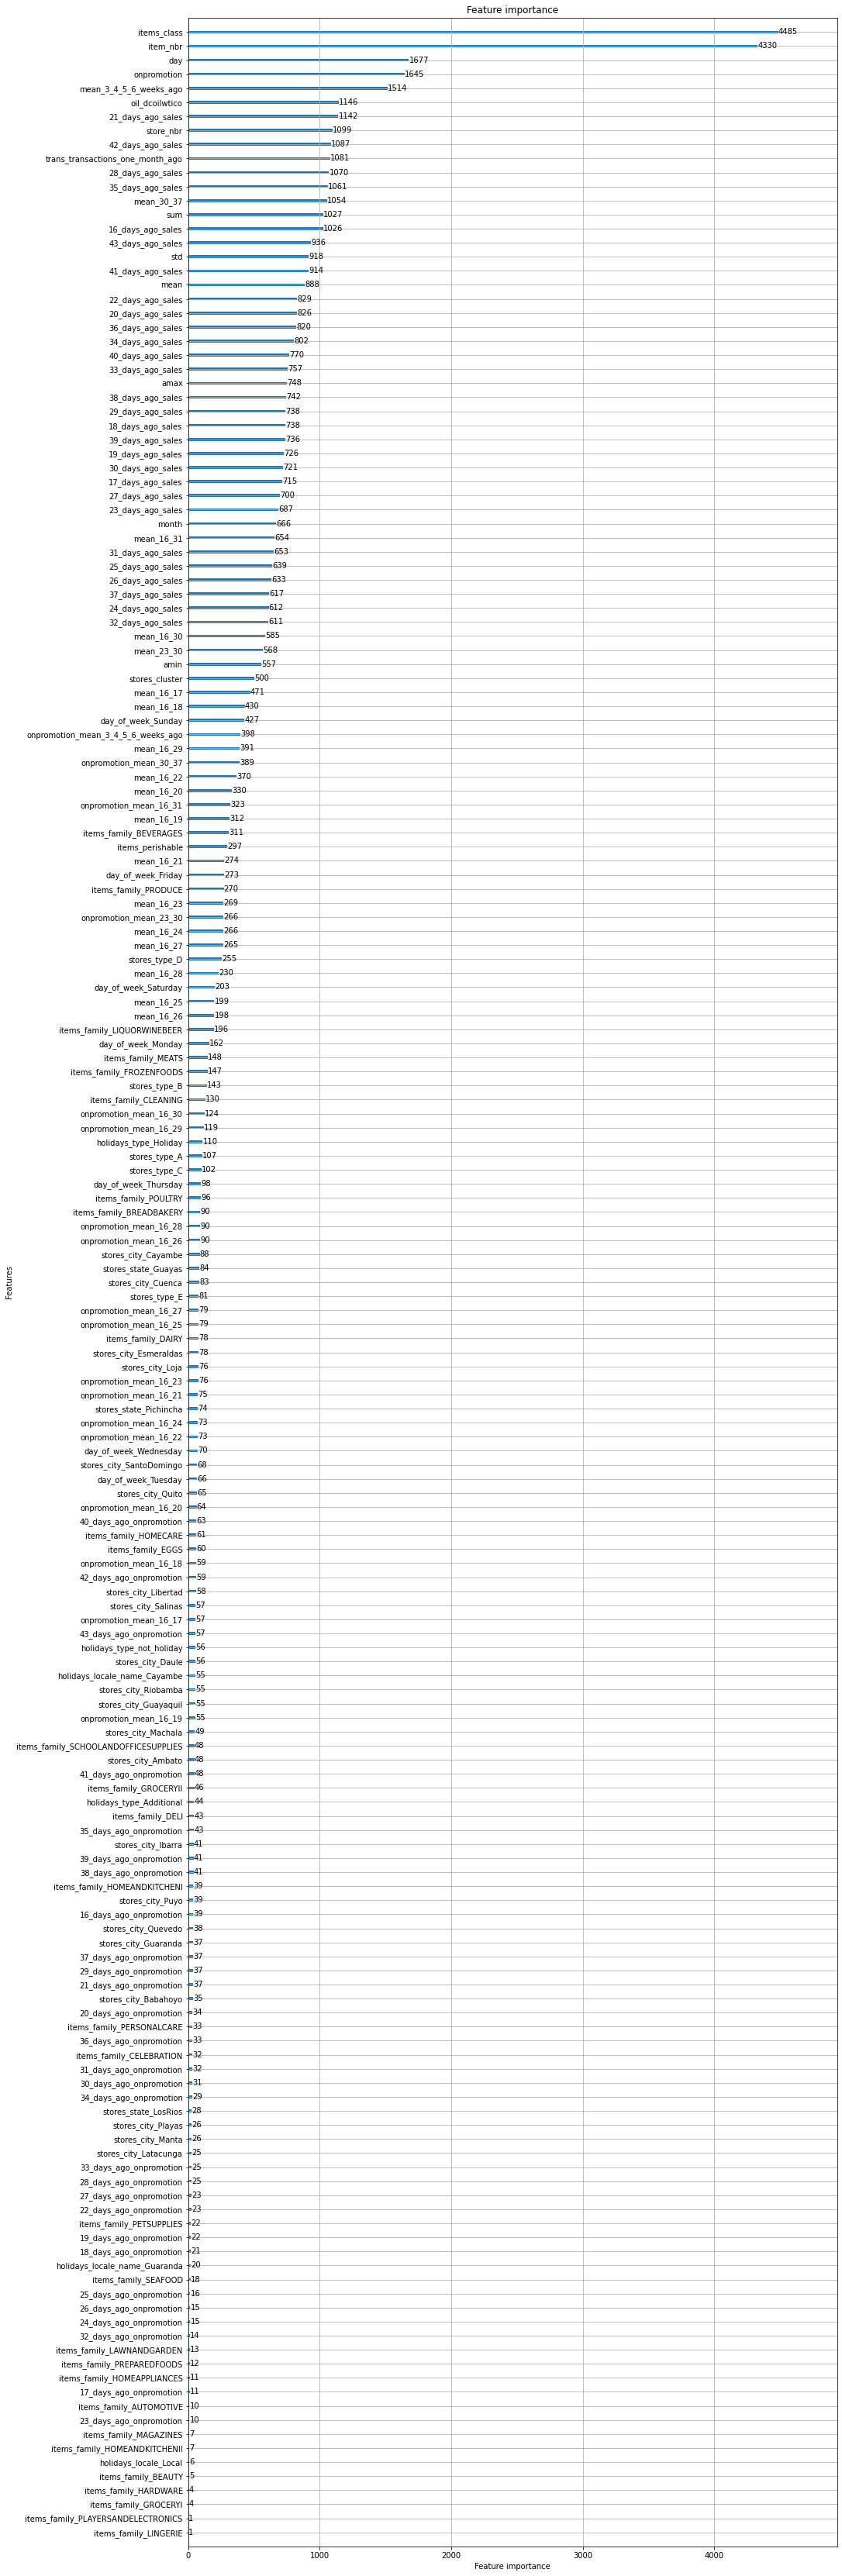

In [41]:
#88

# 特徴量の重要度を確認

fig, ax = plt.subplots(figsize=(15, 60))
lgb.plot_importance(model, ax=ax)
plt.show()

特徴量の重要度を確認:
- item_class(商品のクラス)やitem_nbr(商品番号)が重要度が高い、過去の売上や販売取引回数など新しく作った特徴量も重要度が比較的高い。
- 祝日に関する特徴量はほとんど重要度は低い。

### 5.3 提出ファイルを作成する

In [ ]:
#89

pred = model.predict(X_test)
sample_submission_df["unit_sales"] = np.clip(np.expm1(pred), 0, 10000)
sample_submission_df

In [ ]:
#90

sample_submission_df.to_csv('submission_df_3_9_4.csv', index=False)

- Score: 0.91289
- Private score: 0.89979
- 1671人中1396位
- ちなみに 1位: 0.50918, 500位: 0.52359, 1000位: 0.55598

# 6, 結果、まとめ <a id="6"></a>

- #45 エクアドルは石油産業が盛んで石油価格がエクアドル経済に大きく左右されてい、商品の売上は石油価格と多少は関係されていると思われる。
- #45 2013年から2017年にかけて商品数が2500ほど増えているので、#45のグラフでは、2013年から2017年にかけて商品の売上の平均では下がっているのに対して、商品の売上の合計では上がっている。
- #50 `stores_type`は、B,C,D,Eの商品の売上の中央値は\$4\~5に対してAは\$7で、Aの中でも`stores_cluster`が5の商品の売上の中央値が\$9で最も高い。
- #51 `items_family`は、やはりスーパーなのでpoultry(鶏肉全般)、produce(農産物)、prepared foods(加工食品)などは売上の中央値が高く、baby care(赤ちゃん用品)、hardware(金物類)、beauty(コスメ)などは低い。
- #58 １ヶ月前の`trans_transactions`(指定された店舗のその日の販売取引の数)は商品の売上に相関がある。販売取引が多い店舗は売上が高い。予測したい日の販売取引は分からないので、１ヶ月前の販売取引を特徴量として加えた。
- 過去の売上、販売取引回数を特徴量として加えたらスコアが-----から-----に上がった。
- (決定木の話書く)スケーリングなど特徴量エンジニアリングではスコアは上がらなかった。
- #87 特徴量の重要度(Feature importance)を確認したところ、`item_nbr`と`items_class`が群を抜いて高い。